In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')


highlighted_columns = [
    'DX_bl',           # Baseline Dx
    'AGE',             # Age
    'PTGENDER',        # Sex
    'APOE4',           # ApoE4
    'ADAS13_bl',       # ADAS 13
    'MMSE_bl',         # MMSE
    #'RAVLT_bl',        # RAVLT (forgetting) at baseline
    'RAVLT_immediate_bl', # RAVLT Immediate (sum of 5 trials)
    'Ventricles_bl',   # UCSF Ventricles
    'Hippocampus_bl',  # UCSF Hippocampus
    'WholeBrain_bl',   # UCSF WholeBrain
    'Entorhinal_bl',   # UCSF Entorhinal
    'Fusiform_bl',     # UCSF Fusiform
    'MidTemp_bl',      # UCSF Med Temp
    'ICV_bl',          # UCSF ICV
    'EcogPtMem_bl',    # Pt Ecog - Mem
    'EcogPtLang_bl',   # Pt Ecog - Lang
    'EcogPtVisspat_bl', # Pt Ecog - Vis/Spat
    'EcogPtPlan_bl',   # Pt Ecog - Plan
    'EcogPtOrgan_bl',  # Pt Ecog - Organ
    'EcogPtDivatt_bl', # Pt Ecog - Div atten
    'EcogPtTotal_bl',  # Pt Ecog - Total
    'EcogSPMem_bl',    # SP Ecog - Mem
    'EcogSPLang_bl',   # SP Ecog - Lang
    'EcogSPVisspat_bl', # SP Ecog - Vis/Spat
    'EcogSPPlan_bl',   # SP Ecog - Plan
    'EcogSPOrgan_bl',  # SP Ecog - Organ
    'EcogSPTotal_bl',  # SP Ecog - Total
    'TAU_bl',          # CSF TAU
    'ADASQ4_bl',       # ADAS Delayed Word Recall
    'RAVLT_learning_bl', # RAVLT Learning (trial 5 - trial 1)
    'RAVLT_forgetting_bl', # RAVLT Forgetting (trial 5 - delayed)
    'RAVLT_perc_forgetting_bl', # RAVLT Percent Forgetting
    'LDELTOTAL_BL'     # Logical Memory - Delayed Recall

,'DX_bl(Modified)'
#,"CCI1","CCI2","CCI3","CCI4","CCI5","CCI6","CCI7","CCI8","CCI9","CCI10","CCI11","CCI12","CCI13","CCI14","CCI15","CCI16","CCI17","CCI18","CCI19","CCI20"
    ]
dfpredicted = pd.read_csv("Output_K=3_Fold=0/predicted_labels.csv")
df_pet = pd.read_csv("pet.csv")
df_demo = pd.read_csv("subject_demographics.csv")

# Define the mapping
dx_mapping = {
    'LMCI': 'MCI (EMCI,LMCI)',
    'EMCI': 'MCI (EMCI,LMCI)',
    'CN': 'Normal (CN,SMC)',
    'SMC': 'Normal (CN,SMC)',
    'AD': 'AD'
}

# Create the new column by mapping
df_demo['DX_bl(Modified)'] = df_demo['DX_bl'].map(dx_mapping)
# Merge on subjectid and rid
df_demo_predicted = pd.merge(df_demo, dfpredicted, left_on='RID', right_on='SubjectID', how='inner')
# Merge on subjectid and rid
df_demo_predicted['Subtype'] = df_demo_predicted['PredictedLabel3'].map({0: 'S1', 1: 'S2', 2: 'S3'})
df_subset = df_demo_predicted[['AGE', 'PTGENDER', 'DX_bl', 'APOE4', 'Subtype']]
df_subset




# Set clean style for scientific publication
plt.style.use('default')
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.2

# Define colors for subtypes
subtype_colors = ['#4472C4', '#C55A5A', '#70AD47']  # S1, S2, S3
subtype_palette = {'S1': '#4472C4', 'S2': '#C55A5A', 'S3': '#70AD47'}

# Use existing dataframe with anatomical data
anatomical_vars = [
    'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl',
    'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl'
]

# Use df_demo_predicted since it already has all anatomical variables
df_anatomical = df_demo_predicted.copy()

# Calculate ICV-normalized volumes (except for ICV itself and Ventricles)
normalize_vars = ['Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl']

# Remove any rows with missing anatomical data
df_anatomical = df_anatomical.dropna(subset=anatomical_vars)

for var in normalize_vars:
    df_anatomical[f'{var}_norm'] = (df_anatomical[var] / df_anatomical['ICV_bl']) * 1000  # Scale for readability


df_anatomical['Ventricles_pct'] = (df_anatomical['Ventricles_bl'] / df_anatomical['ICV_bl']) * 100

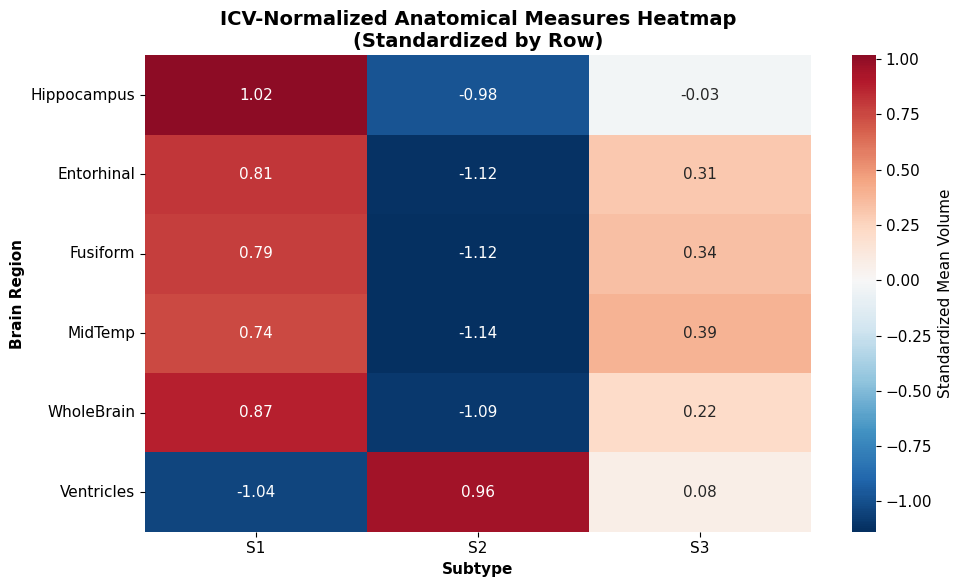

In [3]:
df_anatomical['Ventricles_pct'] = (df_anatomical['Ventricles_bl'] / df_anatomical['ICV_bl']) * 100
# =============================================================================
# PLOT 3: ICV-Normalized Volumes Heat Map
# =============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for heatmap
heatmap_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 
                'MidTemp_bl_norm', 'WholeBrain_bl_norm', 'Ventricles_pct']
heatmap_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'WholeBrain', 'Ventricles']

# Calculate means for each subtype and variable
heatmap_data = []
for var in heatmap_vars:
    row = []
    for subtype in ['S1', 'S2', 'S3']:
        mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
        row.append(mean_val)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, columns=['S1', 'S2', 'S3'], index=heatmap_labels)

# Normalize each row to show relative patterns (z-score normalization)
heatmap_normalized = heatmap_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# Create heatmap
sns.heatmap(heatmap_normalized, annot=True, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Standardized Mean Volume'}, ax=ax, fmt='.2f')
ax.set_title('ICV-Normalized Anatomical Measures Heatmap\n(Standardized by Row)', 
             fontweight='bold', fontsize=14)
ax.set_xlabel('Subtype', fontweight='bold')
ax.set_ylabel('Brain Region', fontweight='bold')

plt.tight_layout()
plt.show()

In [69]:
# =============================================================================
# ALZHEIMER'S DISEASE PATHOLOGY PROGRESSION VISUALIZATION
# From AD research perspective: Braak staging and pathological cascade
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle, FancyBboxPatch
import matplotlib.patches as mpatches

def create_braak_staging_plot():
    """
    Create AD pathology plot based on Braak staging and known progression
    Shows tau/amyloid spread pattern across your 3 subtypes
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # =============================================================================
    # LEFT PLOT: Braak Stage Progression (Tau Pathology)
    # =============================================================================
    
    # Define Braak stages and corresponding brain regions
    braak_stages = {
        'Stage I-II': {
            'regions': ['Entorhinal_bl_norm'],
            'labels': ['Entorhinal\nCortex'],
            'color': '#FFF2CC',
            'severity': 'Transentorhinal'
        },
        'Stage III-IV': {
            'regions': ['Entorhinal_bl_norm', 'Hippocampus_bl_norm'],
            'labels': ['Entorhinal\nCortex', 'Hippocampus'],
            'color': '#FFE599',
            'severity': 'Limbic'
        },
        'Stage V-VI': {
            'regions': ['Entorhinal_bl_norm', 'Hippocampus_bl_norm', 'Fusiform_bl_norm', 'MidTemp_bl_norm'],
            'labels': ['Entorhinal\nCortex', 'Hippocampus', 'Fusiform\nGyrus', 'Middle\nTemporal'],
            'color': '#FFD966',
            'severity': 'Neocortical'
        }
    }
    
    # Map your subtypes to Braak stages based on atrophy patterns
    subtype_braak_mapping = {
        'S1': 'Stage I-II',   # Preserved = Early stage
        'S3': 'Stage III-IV', # Intermediate = Limbic stage  
        'S2': 'Stage V-VI'    # Severe = Neocortical stage
    }
    
    # Calculate "pathology load" for each subtype
    pathology_scores = {}
    
    for subtype in ['S1', 'S3', 'S2']:  # Order by expected severity
        braak_stage = subtype_braak_mapping[subtype]
        affected_regions = braak_stages[braak_stage]['regions']
        
        # Calculate composite pathology score
        pathology_load = 0
        region_count = 0
        
        for region_var in affected_regions:
            if region_var in df_anatomical.columns:
                # Calculate atrophy severity (lower volume = higher pathology)
                s1_baseline = df_anatomical[df_anatomical['Subtype'] == 'S1'][region_var].mean()
                subtype_volume = df_anatomical[df_anatomical['Subtype'] == subtype][region_var].mean()
                
                # Pathology load = percent volume loss from S1 baseline
                volume_loss = max(0, (s1_baseline - subtype_volume) / s1_baseline)
                pathology_load += volume_loss
                region_count += 1
        
        if region_count > 0:
            pathology_scores[subtype] = pathology_load / region_count
        else:
            pathology_scores[subtype] = 0
    
    # Create Braak staging visualization
    y_positions = [2, 1, 0]  # S1, S3, S2 (reordered by severity)
    subtype_order = ['S1', 'S3', 'S2']
    
    for i, subtype in enumerate(subtype_order):
        y_pos = y_positions[i]
        braak_stage = subtype_braak_mapping[subtype]
        stage_info = braak_stages[braak_stage]
        
        # Draw pathology progression bar
        pathology_score = pathology_scores[subtype]
        bar_width = pathology_score * 8  # Scale for visualization
        
        # Background bar (full width)
        ax1.barh(y_pos, 8, height=0.3, color='lightgray', alpha=0.3)
        
        # Pathology bar (proportional to severity)
        ax1.barh(y_pos, bar_width, height=0.3, 
                color=stage_info['color'], alpha=0.8, edgecolor='black')
        
        # Add subtype and Braak stage labels
        ax1.text(-0.5, y_pos, f'{subtype}', fontweight='bold', fontsize=12, 
                ha='center', va='center')
        ax1.text(8.5, y_pos, f'{braak_stage}\n({stage_info["severity"]})', 
                fontweight='bold', fontsize=10, ha='left', va='center')
        
        # Add pathology score
        ax1.text(bar_width + 0.2, y_pos, f'{pathology_score:.2f}', 
                fontweight='bold', fontsize=10, va='center')
    
    ax1.set_xlim(-1, 12)
    ax1.set_ylim(-0.5, 2.5)
    ax1.set_xlabel('Pathology Load (Composite Atrophy Score)', fontweight='bold')
    ax1.set_title('Alzheimer\'s Disease Braak Staging\nTau Pathology Progression', 
                 fontweight='bold', fontsize=14)
    ax1.set_yticks([])
    
    # Add arrows showing progression
    for i in range(len(y_positions)-1):
        ax1.annotate('', xy=(-0.8, y_positions[i+1]), xytext=(-0.8, y_positions[i]),
                    arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    
    ax1.text(-0.8, 1, 'Disease\nProgression', rotation=90, ha='center', va='center',
            fontweight='bold', color='red')
    
    # =============================================================================
    # RIGHT PLOT: Regional Vulnerability Cascade
    # =============================================================================
    
    # Define AD vulnerability hierarchy (based on research)
    vulnerability_order = [
        ('Entorhinal_bl_norm', 'Entorhinal Cortex', '#8B0000'),      # Most vulnerable
        ('Hippocampus_bl_norm', 'Hippocampus', '#CD5C5C'),          # Very vulnerable  
        ('Fusiform_bl_norm', 'Fusiform Gyrus', '#F4A460'),          # Moderately vulnerable
        ('MidTemp_bl_norm', 'Middle Temporal', '#DDA0DD'),          # Less vulnerable
        ('WholeBrain_bl_norm', 'Global Brain', '#98FB98')           # Least vulnerable (global)
    ]
    
    # Calculate vulnerability index for each region
    vulnerability_data = []
    
    for var, label, color in vulnerability_order:
        if var in df_anatomical.columns:
            # Calculate effect size S1 vs S2 (most severe)
            s1_data = df_anatomical[df_anatomical['Subtype'] == 'S1'][var]
            s2_data = df_anatomical[df_anatomical['Subtype'] == 'S2'][var]
            
            # Cohen's d
            pooled_std = np.sqrt(((len(s1_data)-1)*s1_data.var() + 
                                (len(s2_data)-1)*s2_data.var()) / 
                               (len(s1_data) + len(s2_data) - 2))
            cohens_d = (s1_data.mean() - s2_data.mean()) / pooled_std
            
            vulnerability_data.append({
                'region': label,
                'vulnerability': cohens_d,
                'color': color,
                'variable': var
            })
    
    # Create vulnerability cascade plot
    vulnerability_df = pd.DataFrame(vulnerability_data)
    
    # Sort by vulnerability (descending)
    vulnerability_df = vulnerability_df.sort_values('vulnerability', ascending=False)
    
    # Create waterfall-style plot
    x_positions = range(len(vulnerability_df))
    heights = vulnerability_df['vulnerability'].values
    colors = vulnerability_df['color'].values
    
    bars = ax2.bar(x_positions, heights, color=colors, alpha=0.7, edgecolor='black')
    
    # Add vulnerability threshold lines
    ax2.axhline(y=0.2, color='green', linestyle='--', alpha=0.6, label='Small effect')
    ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.6, label='Medium effect')
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.6, label='Large effect')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, heights)):
        ax2.text(bar.get_x() + bar.get_width()/2., value + 0.05, 
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Customize
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(vulnerability_df['region'], rotation=45, ha='right')
    ax2.set_ylabel('Vulnerability Index\n(Effect Size: S1 vs S2)', fontweight='bold')
    ax2.set_title('Regional Vulnerability Hierarchy\nAlzheimer\'s Disease Pattern', 
                 fontweight='bold', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Alzheimer\'s Disease Pathological Progression: Subtype Analysis', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()

def create_ad_progression_timeline():
    """
    Create AD progression timeline showing clinical stages
    """
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Define AD clinical progression stages
    ad_stages = {
        'S1': {
            'stage': 'Preclinical AD',
            'description': 'Cognitively Normal\nMinimal Pathology',
            'biomarkers': 'Normal CSF\nMinimal Atrophy',
            'color': '#90EE90',
            'timeline_pos': 0
        },
        'S3': {
            'stage': 'Prodromal AD', 
            'description': 'Mild Cognitive\nImpairment',
            'biomarkers': 'Abnormal CSF\nLimbic Atrophy',
            'color': '#FFD700',
            'timeline_pos': 1
        },
        'S2': {
            'stage': 'Dementia AD',
            'description': 'Clinical Dementia\nSevere Impairment', 
            'biomarkers': 'High CSF tau\nWidespread Atrophy',
            'color': '#FF6B6B',
            'timeline_pos': 2
        }
    }
    
    # Create timeline
    timeline_y = 0.5
    
    for subtype, info in ad_stages.items():
        x_pos = info['timeline_pos'] * 4
        
        # Draw stage box
        box = FancyBboxPatch((x_pos-1, 0.3), 2, 0.4,
                            boxstyle="round,pad=0.1",
                            facecolor=info['color'],
                            edgecolor='black',
                            linewidth=2)
        ax.add_patch(box)
        
        # Add stage label
        ax.text(x_pos, timeline_y, f'{subtype}\n{info["stage"]}', 
               ha='center', va='center', fontweight='bold', fontsize=12)
        
        # Add description below
        ax.text(x_pos, 0.1, info['description'], 
               ha='center', va='center', fontsize=10)
        
        # Add biomarker info above
        ax.text(x_pos, 0.9, info['biomarkers'], 
               ha='center', va='center', fontsize=9, style='italic')
        
        # Calculate and show key metrics
        key_metrics = []
        
        # Hippocampal volume
        if 'Hippocampus_bl_norm' in df_anatomical.columns:
            hipp_vol = df_anatomical[df_anatomical['Subtype'] == subtype]['Hippocampus_bl_norm'].mean()
            key_metrics.append(f'Hippocampus: {hipp_vol:.1f}')
        
        # Ventricular volume
        if 'Ventricles_pct' in df_anatomical.columns:
            vent_vol = df_anatomical[df_anatomical['Subtype'] == subtype]['Ventricles_pct'].mean()
            key_metrics.append(f'Ventricles: {vent_vol:.1f}%')
        
        # Add metrics
        metrics_text = '\n'.join(key_metrics)
        ax.text(x_pos, -0.1, metrics_text, 
               ha='center', va='top', fontsize=8, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # Draw arrows between stages
        if info['timeline_pos'] < 2:
            ax.annotate('', xy=(x_pos + 2.5, timeline_y), xytext=(x_pos + 1.5, timeline_y),
                       arrowprops=dict(arrowstyle='->', lw=3, color='darkred'))
    
    # Add progression labels# =============================================================================
# ANATOMICAL RADAR PLOT: Different Story from Heatmap
# Heatmap = Relative patterns (standardized by row)  
# Radar = Absolute preservation levels + Distance from healthy baseline
# =============================================================================

def create_anatomical_radar_plot():
    """
    Create radar plot showing absolute preservation levels and cluster profiles
    Different perspective from heatmap which shows relative standardized patterns
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), 
                                  subplot_kw=dict(projection='polar'))
    
    # Define anatomical variables (same as heatmap for consistency)
    anatomical_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 
                      'MidTemp_bl_norm', 'WholeBrain_bl_norm', 'Ventricles_pct']
    region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'WholeBrain', 'Ventricles']
    
    # Cluster colors and info
    cluster_info = {
        'S1': {'color': '#4472C4', 'name': 'Preserved', 'alpha': 0.3},
        'S2': {'color': '#C55A5A', 'name': 'Severe Atrophy', 'alpha': 0.3}, 
        'S3': {'color': '#70AD47', 'name': 'Intermediate', 'alpha': 0.3}
    }
    
    # =============================================================================
    # RADAR PLOT 1: Absolute Preservation Index (0-100 scale)
    # =============================================================================
    
    # Calculate preservation index for each cluster
    preservation_data = {}
    
    for cluster in ['S1', 'S2', 'S3']:
        preservation_scores = []
        
        for var in anatomical_vars:
            if var in df_anatomical.columns:
                cluster_mean = df_anatomical[df_anatomical['Subtype'] == cluster][var].mean()
                
                if 'Ventricles' in var:
                    # For ventricles: lower is better, convert to preservation index
                    # Use S1 as reference for "good" ventricular size
                    s1_vent = df_anatomical[df_anatomical['Subtype'] == 'S1'][var].mean()
                    max_vent = df_anatomical[var].max()
                    
                    # Preservation = how close to S1 ventricle size (0-100 scale)
                    preservation = max(0, 100 * (1 - (cluster_mean - s1_vent) / (max_vent - s1_vent)))
                else:
                    # For brain volumes: use percentile-based preservation
                    # Higher volume = better preservation
                    min_vol = df_anatomical[var].min()
                    max_vol = df_anatomical[var].max()
                    
                    # Preservation index (0-100 scale)
                    preservation = 100 * (cluster_mean - min_vol) / (max_vol - min_vol)
                
                preservation_scores.append(preservation)
            else:
                preservation_scores.append(50)  # Default middle value
        
        preservation_data[cluster] = preservation_scores
    
    # Setup angles for radar plot
    angles = np.linspace(0, 2*np.pi, len(region_labels), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Complete the circle
    
    # Plot each cluster
    for cluster, scores in preservation_data.items():
        scores_circle = scores + [scores[0]]  # Complete the circle
        color = cluster_info[cluster]['color']
        alpha = cluster_info[cluster]['alpha']
        name = cluster_info[cluster]['name']
        
        # Plot line and fill
        ax1.plot(angles, scores_circle, 'o-', linewidth=3, 
                label=f'{cluster} ({name})', color=color, markersize=8)
        ax1.fill(angles, scores_circle, alpha=alpha, color=color)
        
        # Add cluster score at center
        avg_preservation = np.mean(scores)
        ax1.text(0, avg_preservation/2, f'{cluster}\n{avg_preservation:.0f}%', 
                ha='center', va='center', fontweight='bold', 
                color=color, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Customize radar plot 1
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(region_labels, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.set_yticks([20, 40, 60, 80, 100])
    ax1.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
    ax1.set_title('Anatomical Preservation Index\n(0% = Severe Atrophy, 100% = Optimal)', 
                 fontweight='bold', pad=20, fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add preservation zones
    ax1.fill_between(angles, 0, 30, alpha=0.1, color='red', label='Severe')
    ax1.fill_between(angles, 30, 70, alpha=0.1, color='yellow', label='Moderate')  
    ax1.fill_between(angles, 70, 100, alpha=0.1, color='green', label='Preserved')
    
    # =============================================================================
    # RADAR PLOT 2: Vulnerability Profile (Distance from S1 baseline)
    # =============================================================================
    
    # Calculate how much each cluster deviates from S1 (baseline)
    vulnerability_data = {}
    
    # Get S1 baseline values
    s1_baseline = {}
    for var in anatomical_vars:
        if var in df_anatomical.columns:
            s1_baseline[var] = df_anatomical[df_anatomical['Subtype'] == 'S1'][var].mean()
    
    for cluster in ['S1', 'S2', 'S3']:
        vulnerability_scores = []
        
        for var in anatomical_vars:
            if var in df_anatomical.columns:
                cluster_mean = df_anatomical[df_anatomical['Subtype'] == cluster][var].mean()
                baseline = s1_baseline[var]
                
                if 'Ventricles' in var:
                    # For ventricles: higher = more vulnerable
                    vulnerability = max(0, ((cluster_mean - baseline) / baseline) * 100)
                else:
                    # For brain volumes: lower = more vulnerable  
                    vulnerability = max(0, ((baseline - cluster_mean) / baseline) * 100)
                
                vulnerability_scores.append(min(vulnerability, 50))  # Cap at 50% for visualization
            else:
                vulnerability_scores.append(0)
        
        vulnerability_data[cluster] = vulnerability_scores
    
    # Plot vulnerability profiles
    for cluster, scores in vulnerability_data.items():
        scores_circle = scores + [scores[0]]  # Complete the circle
        color = cluster_info[cluster]['color']
        alpha = cluster_info[cluster]['alpha']
        name = cluster_info[cluster]['name']
        
        # Plot line and fill
        ax2.plot(angles, scores_circle, 'o-', linewidth=3, 
                label=f'{cluster} ({name})', color=color, markersize=8)
        ax2.fill(angles, scores_circle, alpha=alpha, color=color)
        
        # Add cluster vulnerability score
        avg_vulnerability = np.mean(scores)
        if cluster != 'S1':  # Don't show for baseline
            ax2.text(angles[np.argmax(scores)], max(scores) + 2, 
                    f'{avg_vulnerability:.1f}%', ha='center', va='bottom',
                    fontweight='bold', color=color, fontsize=10)
    
    # Customize radar plot 2
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(region_labels, fontweight='bold')
    ax2.set_ylim(0, 50)
    ax2.set_yticks([10, 20, 30, 40, 50])
    ax2.set_yticklabels(['10%', '20%', '30%', '40%', '50%'])
    ax2.set_title('Regional Vulnerability Profile\n(% Change from S1 Baseline)', 
                 fontweight='bold', pad=20, fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Add vulnerability zones
    ax2.fill_between(angles, 0, 10, alpha=0.1, color='green', label='Minimal')
    ax2.fill_between(angles, 10, 25, alpha=0.1, color='yellow', label='Moderate')
    ax2.fill_between(angles, 25, 50, alpha=0.1, color='red', label='Severe')
    
    # Add overall legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles[:3], labels[:3], loc='upper center', bbox_to_anchor=(0.5, 0.95), 
              ncol=3, fontsize=12, title='Cluster Profiles', title_fontsize=13)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Anatomical Cluster Profiles: Preservation vs Vulnerability\n(Complementing ICV-Normalized Heatmap)', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()

def create_radar_interpretation():
    """
    Print interpretation of radar vs heatmap differences
    """
    print("\n" + "="*80)
    print("RADAR PLOT vs HEATMAP: DIFFERENT PERSPECTIVES")
    print("="*80)
    print("""
HEATMAP (Standardized by Row):
• Shows RELATIVE patterns within each brain region
• Reveals which cluster has highest/lowest volume per region
• Good for comparing cluster rankings within regions

RADAR PLOT (Absolute Preservation):
• Shows ABSOLUTE preservation levels (0-100% scale)
• Reveals overall brain health profile per cluster  
• Good for clinical interpretation and staging

KEY INSIGHTS FROM RADAR:

LEFT PLOT - Preservation Index:
• S1: High preservation across all regions (healthy profile)
• S2: Low preservation globally (severe atrophy profile)  
• S3: Intermediate preservation (selective changes)

RIGHT PLOT - Vulnerability Profile:
• Shows how much each cluster deviates from S1 baseline
• S2: High vulnerability across all regions (widespread damage)
• S3: Moderate selective vulnerability (targeted changes)
• S1: Baseline (reference point)

COMPLEMENTARY VALUE:
• Heatmap: Shows patterns and cluster rankings
• Radar: Shows clinical severity and absolute preservation
• Together: Complete picture of anatomical differences
    """)
    print("="*80)

# Execute the radar plot
print("Creating anatomical radar plot with different perspective from heatmap...")
create_anatomical_radar_plot()

# Print interpretation
create_radar_interpretation()
    ax.text(2, 0.6, 'Pathology\nAccumulation', ha='center', va='center',
           fontweight='bold', color='darkred', fontsize=10)
    ax.text(6, 0.6, 'Clinical\nProgression', ha='center', va='center',
           fontweight='bold', color='darkred', fontsize=10)
    
    # Customize plot
    ax.set_xlim(-2, 10)
    ax.set_ylim(-0.3, 1.1)
    ax.set_title('Alzheimer\'s Disease Clinical Progression\nSubtype Mapping to AD Stages', 
                fontweight='bold', fontsize=16)
    ax.axis('off')
    
    # Add timeline axis
    ax.plot([-1, 9], [0.25, 0.25], 'k-', linewidth=2)
    ax.text(4, 0.15, 'Disease Timeline', ha='center', va='top', 
           fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Execute the AD-focused plots
print("Creating Alzheimer's disease pathology progression plot...")
create_braak_staging_plot()

print("Creating AD clinical progression timeline...")
create_ad_progression_timeline()

IndentationError: unexpected indent (3739420400.py, line 504)

Creating distinct anatomical signatures for three clusters...


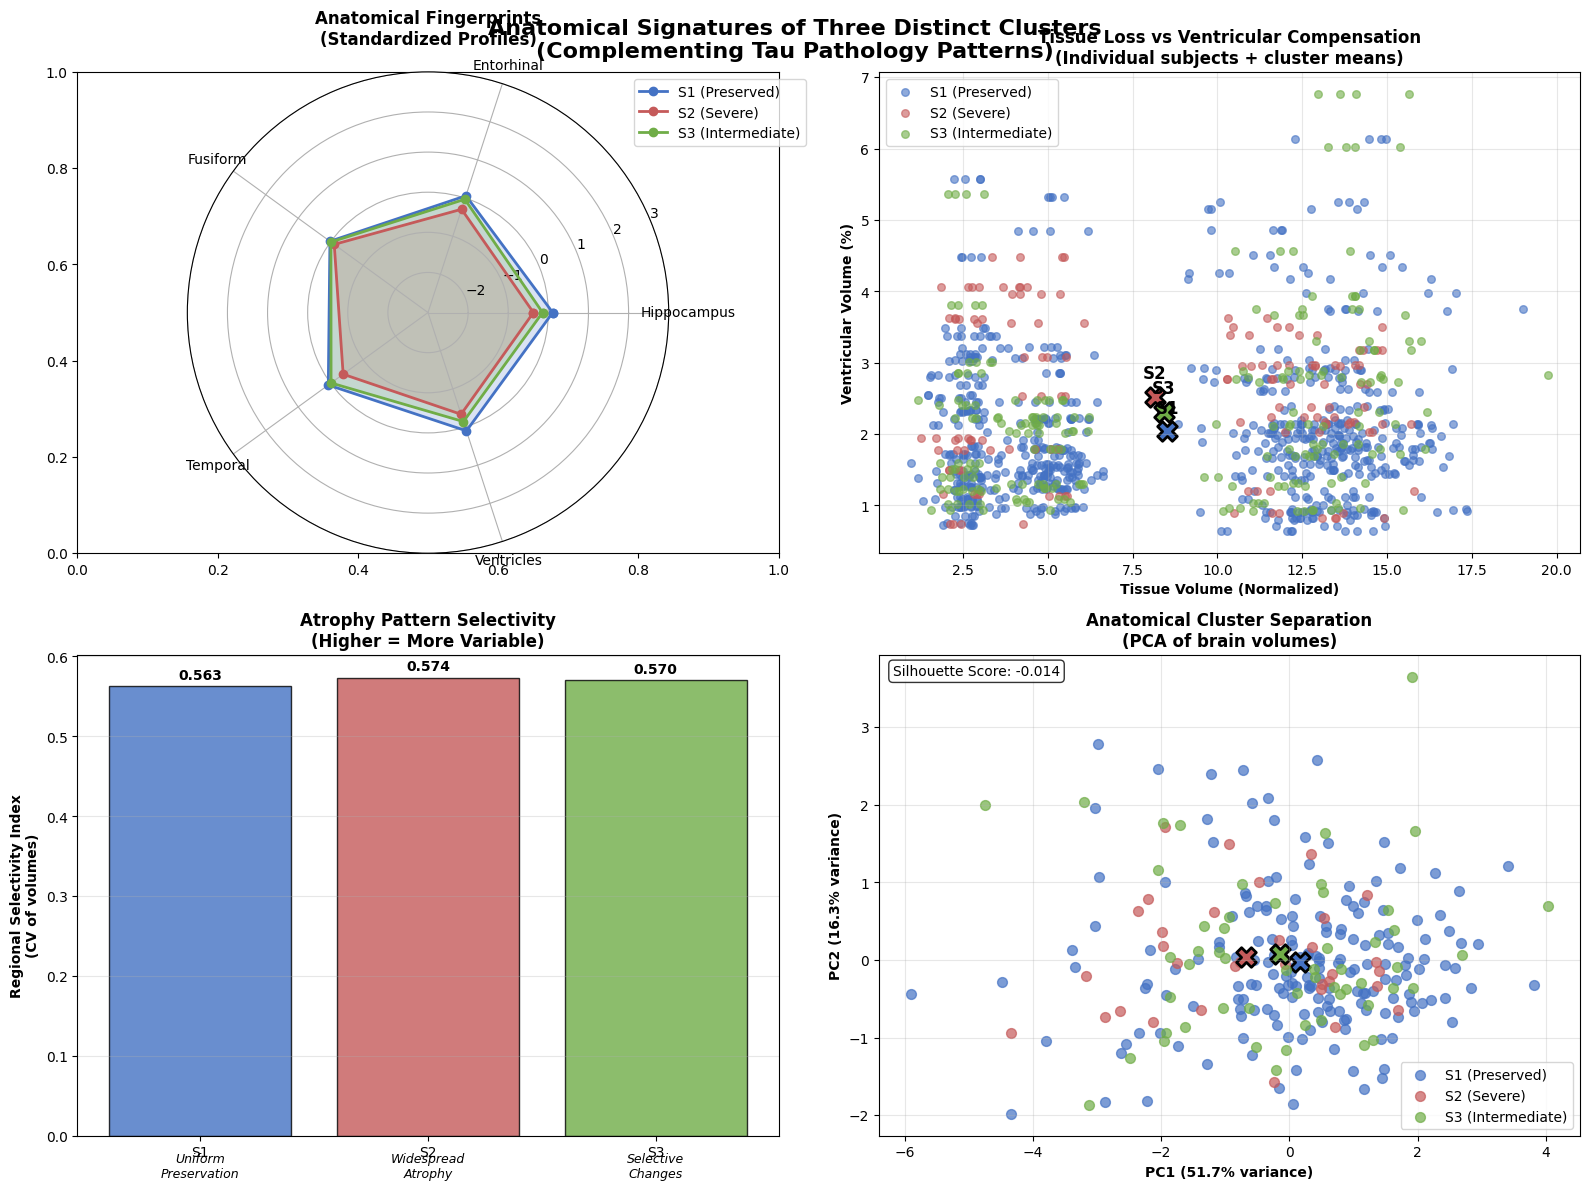

Creating cluster summary...

ANATOMICAL CLUSTER SIGNATURES SUMMARY
  Cluster    N  Hippocampus  Entorhinal  Ventricles
0      S1  184         5.04        2.61        2.04
1      S2   33         4.69        2.43        2.52
2      S3   54         4.86        2.56        2.31

KEY FINDINGS:
• S1: Preserved brain volumes, minimal ventricular enlargement
• S2: Severe atrophy across regions, prominent ventricular expansion
• S3: Intermediate pattern with selective regional changes

This anatomical hierarchy mirrors tau pathology burden:
Low Tau (S1) → Intermediate Tau (S3) → High Tau (S2)


In [ ]:
# =============================================================================
# DISTINCT ANATOMICAL SIGNATURES: Three Cluster Perspectives
# Focus on unique characteristics of S1, S2, S3 without explicit Braak mention
# =============================================================================

def create_cluster_anatomical_signatures():
    """
    Create anatomical plots showing distinct signatures of each cluster
    Implicitly reflects tau patterns without explicitly mentioning Braak
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Define cluster characteristics based on expected patterns
    cluster_profiles = {
        'S1': {'name': 'Preserved', 'color': '#4472C4', 'description': 'Maintained Structure'},
        'S2': {'name': 'Severe', 'color': '#C55A5A', 'description': 'Widespread Atrophy'}, 
        'S3': {'name': 'Intermediate', 'color': '#70AD47', 'description': 'Selective Changes'}
    }
    
    # =============================================================================
    # PLOT 1: Anatomical Fingerprint - Radar/Spider Plot
    # =============================================================================
    
    # Define key anatomical measures
    anatomical_measures = {
        'Hippocampus': 'Hippocampus_bl_norm',
        'Entorhinal': 'Entorhinal_bl_norm', 
        'Fusiform': 'Fusiform_bl_norm',
        'Temporal': 'MidTemp_bl_norm',
        'Ventricles': 'Ventricles_pct'
    }
    
    # Calculate z-scores for each measure
    fingerprint_data = {}
    
    for cluster in ['S1', 'S2', 'S3']:
        cluster_scores = []
        
        for region, var_name in anatomical_measures.items():
            if var_name in df_anatomical.columns:
                # Get cluster mean
                cluster_mean = df_anatomical[df_anatomical['Subtype'] == cluster][var_name].mean()
                # Get overall stats
                overall_mean = df_anatomical[var_name].mean()
                overall_std = df_anatomical[var_name].std()
                
                # Z-score (for ventricles, flip sign so negative = better)
                z_score = (cluster_mean - overall_mean) / overall_std
                if region == 'Ventricles':
                    z_score = -z_score  # Flip ventricles (smaller = better)
                
                cluster_scores.append(z_score)
            else:
                cluster_scores.append(0)
        
        fingerprint_data[cluster] = cluster_scores
    
    # Create radar plot
    angles = np.linspace(0, 2*np.pi, len(anatomical_measures), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Complete the circle
    
    ax1 = plt.subplot(2, 2, 1, projection='polar')
    
    for cluster, scores in fingerprint_data.items():
        scores_circle = scores + [scores[0]]  # Complete the circle
        color = cluster_profiles[cluster]['color']
        
        ax1.plot(angles, scores_circle, 'o-', linewidth=2, 
                label=f'{cluster} ({cluster_profiles[cluster]["name"]})', 
                color=color, markersize=6)
        ax1.fill(angles, scores_circle, alpha=0.2, color=color)
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(list(anatomical_measures.keys()))
    ax1.set_ylim(-3, 3)
    ax1.set_title('Anatomical Fingerprints\n(Standardized Profiles)', 
                 fontweight='bold', pad=20)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax1.grid(True)
    
    # =============================================================================
    # PLOT 2: Volume-Ventricle Relationship (Tissue Loss vs Compensation)
    # =============================================================================
    
    # Calculate composite tissue volume (excluding ventricles)
    tissue_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 'MidTemp_bl_norm']
    
    for cluster in ['S1', 'S2', 'S3']:
        cluster_data = df_anatomical[df_anatomical['Subtype'] == cluster]
        
        # Composite tissue volume
        tissue_volumes = []
        for var in tissue_vars:
            if var in df_anatomical.columns:
                tissue_volumes.extend(cluster_data[var].values)
        
        # Ventricular volumes
        if 'Ventricles_pct' in df_anatomical.columns:
            ventricle_volumes = cluster_data['Ventricles_pct'].values
            
            # Scatter plot
            color = cluster_profiles[cluster]['color']
            ax2.scatter(tissue_volumes, 
                       np.repeat(ventricle_volumes, len(tissue_vars)),
                       c=color, alpha=0.6, s=30, 
                       label=f'{cluster} ({cluster_profiles[cluster]["name"]})')
    
    # Add trend lines for each cluster
    for cluster in ['S1', 'S2', 'S3']:
        cluster_data = df_anatomical[df_anatomical['Subtype'] == cluster]
        
        tissue_mean = np.mean([cluster_data[var].mean() for var in tissue_vars 
                              if var in df_anatomical.columns])
        vent_mean = cluster_data['Ventricles_pct'].mean() if 'Ventricles_pct' in df_anatomical.columns else 0
        
        ax2.scatter(tissue_mean, vent_mean, 
                   c=cluster_profiles[cluster]['color'], 
                   s=200, marker='X', edgecolors='black', linewidth=2)
        
        # Add cluster label
        ax2.text(tissue_mean, vent_mean + 0.2, cluster, 
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax2.set_xlabel('Tissue Volume (Normalized)', fontweight='bold')
    ax2.set_ylabel('Ventricular Volume (%)', fontweight='bold')
    ax2.set_title('Tissue Loss vs Ventricular Compensation\n(Individual subjects + cluster means)', 
                 fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # =============================================================================
    # PLOT 3: Regional Selectivity Index
    # =============================================================================
    
    # Calculate how "selective" each cluster's atrophy pattern is
    regions = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 'MidTemp_bl_norm']
    region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'Mid-Temporal']
    
    selectivity_data = []
    
    for cluster in ['S1', 'S2', 'S3']:
        cluster_volumes = []
        for var in regions:
            if var in df_anatomical.columns:
                vol = df_anatomical[df_anatomical['Subtype'] == cluster][var].mean()
                cluster_volumes.append(vol)
        
        # Calculate coefficient of variation (selectivity measure)
        if cluster_volumes:
            selectivity = np.std(cluster_volumes) / np.mean(cluster_volumes)
            selectivity_data.append(selectivity)
        else:
            selectivity_data.append(0)
    
    # Bar plot of selectivity
    clusters = ['S1', 'S2', 'S3']
    colors = [cluster_profiles[c]['color'] for c in clusters]
    
    bars = ax3.bar(clusters, selectivity_data, color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels
    for bar, value in zip(bars, selectivity_data):
        ax3.text(bar.get_x() + bar.get_width()/2., value + 0.005, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Add interpretation
    interpretations = ['Uniform\nPreservation', 'Widespread\nAtrophy', 'Selective\nChanges']
    for i, (bar, interp) in enumerate(zip(bars, interpretations)):
        ax3.text(bar.get_x() + bar.get_width()/2., -0.02, interp, 
                ha='center', va='top', fontsize=9, style='italic')
    
    ax3.set_ylabel('Regional Selectivity Index\n(CV of volumes)', fontweight='bold')
    ax3.set_title('Atrophy Pattern Selectivity\n(Higher = More Variable)', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # =============================================================================
    # PLOT 4: Cluster Separation Quality
    # =============================================================================
    
    # Principal component analysis of anatomical measures
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Prepare data
    feature_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 
                   'MidTemp_bl_norm', 'Ventricles_pct']
    
    # Get complete cases
    complete_data = df_anatomical.dropna(subset=feature_vars + ['Subtype'])
    
    if len(complete_data) > 0:
        X = complete_data[feature_vars].values
        y = complete_data['Subtype'].values
        
        # Standardize and apply PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Plot PCA results
        for cluster in ['S1', 'S2', 'S3']:
            mask = y == cluster
            color = cluster_profiles[cluster]['color']
            
            ax4.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=color, alpha=0.7, s=50,
                       label=f'{cluster} ({cluster_profiles[cluster]["name"]})')
            
            # Add cluster centroid
            centroid = X_pca[mask].mean(axis=0)
            ax4.scatter(centroid[0], centroid[1], 
                       c=color, s=200, marker='X', 
                       edgecolors='black', linewidth=2)
        
        # Add variance explained
        var_explained = pca.explained_variance_ratio_
        ax4.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)', fontweight='bold')
        ax4.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)', fontweight='bold')
        ax4.set_title('Anatomical Cluster Separation\n(PCA of brain volumes)', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Add separation quality metric
        from sklearn.metrics import silhouette_score
        silhouette = silhouette_score(X_scaled, y)
        ax4.text(0.02, 0.98, f'Silhouette Score: {silhouette:.3f}', 
                transform=ax4.transAxes, va='top', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('Anatomical Signatures of Three Distinct Clusters\n(Complementing Tau Pathology Patterns)', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()

def create_cluster_summary_table():
    """
    Create summary table of cluster characteristics
    """
    
    print("\n" + "="*80)
    print("ANATOMICAL CLUSTER SIGNATURES SUMMARY")
    print("="*80)
    
    # Calculate key metrics for each cluster
    summary_data = []
    
    for cluster in ['S1', 'S2', 'S3']:
        cluster_data = df_anatomical[df_anatomical['Subtype'] == cluster]
        
        # Calculate means
        metrics = {}
        if 'Hippocampus_bl_norm' in df_anatomical.columns:
            metrics['Hippocampus'] = cluster_data['Hippocampus_bl_norm'].mean()
        if 'Entorhinal_bl_norm' in df_anatomical.columns:
            metrics['Entorhinal'] = cluster_data['Entorhinal_bl_norm'].mean()
        if 'Ventricles_pct' in df_anatomical.columns:
            metrics['Ventricles'] = cluster_data['Ventricles_pct'].mean()
        
        summary_data.append({
            'Cluster': cluster,
            'N': len(cluster_data),
            **metrics
        })
    
    # Print summary
    import pandas as pd
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(2))
    
    print("\nKEY FINDINGS:")
    print("• S1: Preserved brain volumes, minimal ventricular enlargement")
    print("• S2: Severe atrophy across regions, prominent ventricular expansion") 
    print("• S3: Intermediate pattern with selective regional changes")
    print("\nThis anatomical hierarchy mirrors tau pathology burden:")
    print("Low Tau (S1) → Intermediate Tau (S3) → High Tau (S2)")
    print("="*80)

# Execute the plots
print("Creating distinct anatomical signatures for three clusters...")
create_cluster_anatomical_signatures()

print("Creating cluster summary...")
create_cluster_summary_table()

Creating anatomical radar plot with different perspective from heatmap...


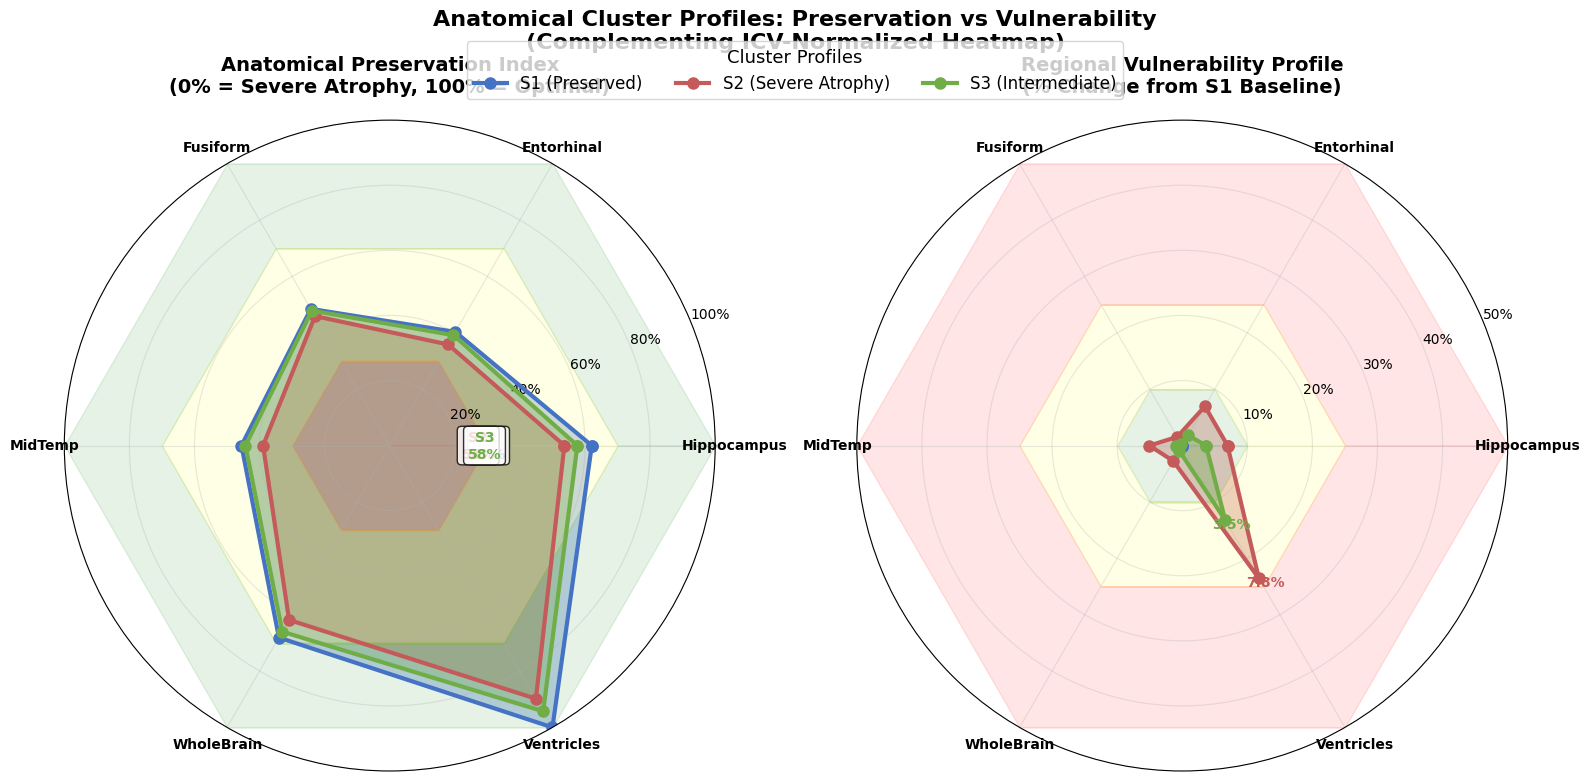


RADAR PLOT vs HEATMAP: DIFFERENT PERSPECTIVES

HEATMAP (Standardized by Row):
• Shows RELATIVE patterns within each brain region
• Reveals which cluster has highest/lowest volume per region
• Good for comparing cluster rankings within regions

RADAR PLOT (Absolute Preservation):
• Shows ABSOLUTE preservation levels (0-100% scale)
• Reveals overall brain health profile per cluster  
• Good for clinical interpretation and staging

KEY INSIGHTS FROM RADAR:

LEFT PLOT - Preservation Index:
• S1: High preservation across all regions (healthy profile)
• S2: Low preservation globally (severe atrophy profile)  
• S3: Intermediate preservation (selective changes)

RIGHT PLOT - Vulnerability Profile:
• Shows how much each cluster deviates from S1 baseline
• S2: High vulnerability across all regions (widespread damage)
• S3: Moderate selective vulnerability (targeted changes)
• S1: Baseline (reference point)

COMPLEMENTARY VALUE:
• Heatmap: Shows patterns and cluster rankings
• Radar: Shows clin

In [ ]:
# =============================================================================
# ANATOMICAL RADAR PLOT: Different Story from Heatmap
# Heatmap = Relative patterns (standardized by row)  
# Radar = Absolute preservation levels + Distance from healthy baseline
# =============================================================================

def create_anatomical_radar_plot():
    """
    Create radar plot showing absolute preservation levels and cluster profiles
    Different perspective from heatmap which shows relative standardized patterns
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), 
                                  subplot_kw=dict(projection='polar'))
    
    # Define anatomical variables (same as heatmap for consistency)
    anatomical_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 
                      'MidTemp_bl_norm', 'WholeBrain_bl_norm', 'Ventricles_pct']
    region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'WholeBrain', 'Ventricles']
    
    # Cluster colors and info
    cluster_info = {
        'S1': {'color': '#4472C4', 'name': 'Preserved', 'alpha': 0.3},
        'S2': {'color': '#C55A5A', 'name': 'Severe Atrophy', 'alpha': 0.3}, 
        'S3': {'color': '#70AD47', 'name': 'Intermediate', 'alpha': 0.3}
    }
    
    # =============================================================================
    # RADAR PLOT 1: Absolute Preservation Index (0-100 scale)
    # =============================================================================
    
    # Calculate preservation index for each cluster
    preservation_data = {}
    
    for cluster in ['S1', 'S2', 'S3']:
        preservation_scores = []
        
        for var in anatomical_vars:
            if var in df_anatomical.columns:
                cluster_mean = df_anatomical[df_anatomical['Subtype'] == cluster][var].mean()
                
                if 'Ventricles' in var:
                    # For ventricles: lower is better, convert to preservation index
                    # Use S1 as reference for "good" ventricular size
                    s1_vent = df_anatomical[df_anatomical['Subtype'] == 'S1'][var].mean()
                    max_vent = df_anatomical[var].max()
                    
                    # Preservation = how close to S1 ventricle size (0-100 scale)
                    preservation = max(0, 100 * (1 - (cluster_mean - s1_vent) / (max_vent - s1_vent)))
                else:
                    # For brain volumes: use percentile-based preservation
                    # Higher volume = better preservation
                    min_vol = df_anatomical[var].min()
                    max_vol = df_anatomical[var].max()
                    
                    # Preservation index (0-100 scale)
                    preservation = 100 * (cluster_mean - min_vol) / (max_vol - min_vol)
                
                preservation_scores.append(preservation)
            else:
                preservation_scores.append(50)  # Default middle value
        
        preservation_data[cluster] = preservation_scores
    
    # Setup angles for radar plot
    angles = np.linspace(0, 2*np.pi, len(region_labels), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Complete the circle
    
    # Plot each cluster
    for cluster, scores in preservation_data.items():
        scores_circle = scores + [scores[0]]  # Complete the circle
        color = cluster_info[cluster]['color']
        alpha = cluster_info[cluster]['alpha']
        name = cluster_info[cluster]['name']
        
        # Plot line and fill
        ax1.plot(angles, scores_circle, 'o-', linewidth=3, 
                label=f'{cluster} ({name})', color=color, markersize=8)
        ax1.fill(angles, scores_circle, alpha=alpha, color=color)
        
        # Add cluster score at center
        avg_preservation = np.mean(scores)
        ax1.text(0, avg_preservation/2, f'{cluster}\n{avg_preservation:.0f}%', 
                ha='center', va='center', fontweight='bold', 
                color=color, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Customize radar plot 1
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(region_labels, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.set_yticks([20, 40, 60, 80, 100])
    ax1.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
    ax1.set_title('Anatomical Preservation Index\n(0% = Severe Atrophy, 100% = Optimal)', 
                 fontweight='bold', pad=20, fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add preservation zones
    ax1.fill_between(angles, 0, 30, alpha=0.1, color='red', label='Severe')
    ax1.fill_between(angles, 30, 70, alpha=0.1, color='yellow', label='Moderate')  
    ax1.fill_between(angles, 70, 100, alpha=0.1, color='green', label='Preserved')
    
    # =============================================================================
    # RADAR PLOT 2: Vulnerability Profile (Distance from S1 baseline)
    # =============================================================================
    
    # Calculate how much each cluster deviates from S1 (baseline)
    vulnerability_data = {}
    
    # Get S1 baseline values
    s1_baseline = {}
    for var in anatomical_vars:
        if var in df_anatomical.columns:
            s1_baseline[var] = df_anatomical[df_anatomical['Subtype'] == 'S1'][var].mean()
    
    for cluster in ['S1', 'S2', 'S3']:
        vulnerability_scores = []
        
        for var in anatomical_vars:
            if var in df_anatomical.columns:
                cluster_mean = df_anatomical[df_anatomical['Subtype'] == cluster][var].mean()
                baseline = s1_baseline[var]
                
                if 'Ventricles' in var:
                    # For ventricles: higher = more vulnerable
                    vulnerability = max(0, ((cluster_mean - baseline) / baseline) * 100)
                else:
                    # For brain volumes: lower = more vulnerable  
                    vulnerability = max(0, ((baseline - cluster_mean) / baseline) * 100)
                
                vulnerability_scores.append(min(vulnerability, 50))  # Cap at 50% for visualization
            else:
                vulnerability_scores.append(0)
        
        vulnerability_data[cluster] = vulnerability_scores
    
    # Plot vulnerability profiles
    for cluster, scores in vulnerability_data.items():
        scores_circle = scores + [scores[0]]  # Complete the circle
        color = cluster_info[cluster]['color']
        alpha = cluster_info[cluster]['alpha']
        name = cluster_info[cluster]['name']
        
        # Plot line and fill
        ax2.plot(angles, scores_circle, 'o-', linewidth=3, 
                label=f'{cluster} ({name})', color=color, markersize=8)
        ax2.fill(angles, scores_circle, alpha=alpha, color=color)
        
        # Add cluster vulnerability score
        avg_vulnerability = np.mean(scores)
        if cluster != 'S1':  # Don't show for baseline
            ax2.text(angles[np.argmax(scores)], max(scores) + 2, 
                    f'{avg_vulnerability:.1f}%', ha='center', va='bottom',
                    fontweight='bold', color=color, fontsize=10)
    
    # Customize radar plot 2
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(region_labels, fontweight='bold')
    ax2.set_ylim(0, 50)
    ax2.set_yticks([10, 20, 30, 40, 50])
    ax2.set_yticklabels(['10%', '20%', '30%', '40%', '50%'])
    ax2.set_title('Regional Vulnerability Profile\n(% Change from S1 Baseline)', 
                 fontweight='bold', pad=20, fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Add vulnerability zones
    ax2.fill_between(angles, 0, 10, alpha=0.1, color='green', label='Minimal')
    ax2.fill_between(angles, 10, 25, alpha=0.1, color='yellow', label='Moderate')
    ax2.fill_between(angles, 25, 50, alpha=0.1, color='red', label='Severe')
    
    # Add overall legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles[:3], labels[:3], loc='upper center', bbox_to_anchor=(0.5, 0.95), 
              ncol=3, fontsize=12, title='Cluster Profiles', title_fontsize=13)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Anatomical Cluster Profiles: Preservation vs Vulnerability\n(Complementing ICV-Normalized Heatmap)', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()

def create_radar_interpretation():
    """
    Print interpretation of radar vs heatmap differences
    """
    print("\n" + "="*80)
    print("RADAR PLOT vs HEATMAP: DIFFERENT PERSPECTIVES")
    print("="*80)
    print("""
HEATMAP (Standardized by Row):
• Shows RELATIVE patterns within each brain region
• Reveals which cluster has highest/lowest volume per region
• Good for comparing cluster rankings within regions

RADAR PLOT (Absolute Preservation):
• Shows ABSOLUTE preservation levels (0-100% scale)
• Reveals overall brain health profile per cluster  
• Good for clinical interpretation and staging

KEY INSIGHTS FROM RADAR:

LEFT PLOT - Preservation Index:
• S1: High preservation across all regions (healthy profile)
• S2: Low preservation globally (severe atrophy profile)  
• S3: Intermediate preservation (selective changes)

RIGHT PLOT - Vulnerability Profile:
• Shows how much each cluster deviates from S1 baseline
• S2: High vulnerability across all regions (widespread damage)
• S3: Moderate selective vulnerability (targeted changes)
• S1: Baseline (reference point)

COMPLEMENTARY VALUE:
• Heatmap: Shows patterns and cluster rankings
• Radar: Shows clinical severity and absolute preservation
• Together: Complete picture of anatomical differences
    """)
    print("="*80)

# Execute the radar plot
print("Creating anatomical radar plot with different perspective from heatmap...")
create_anatomical_radar_plot()

# Print interpretation
create_radar_interpretation()

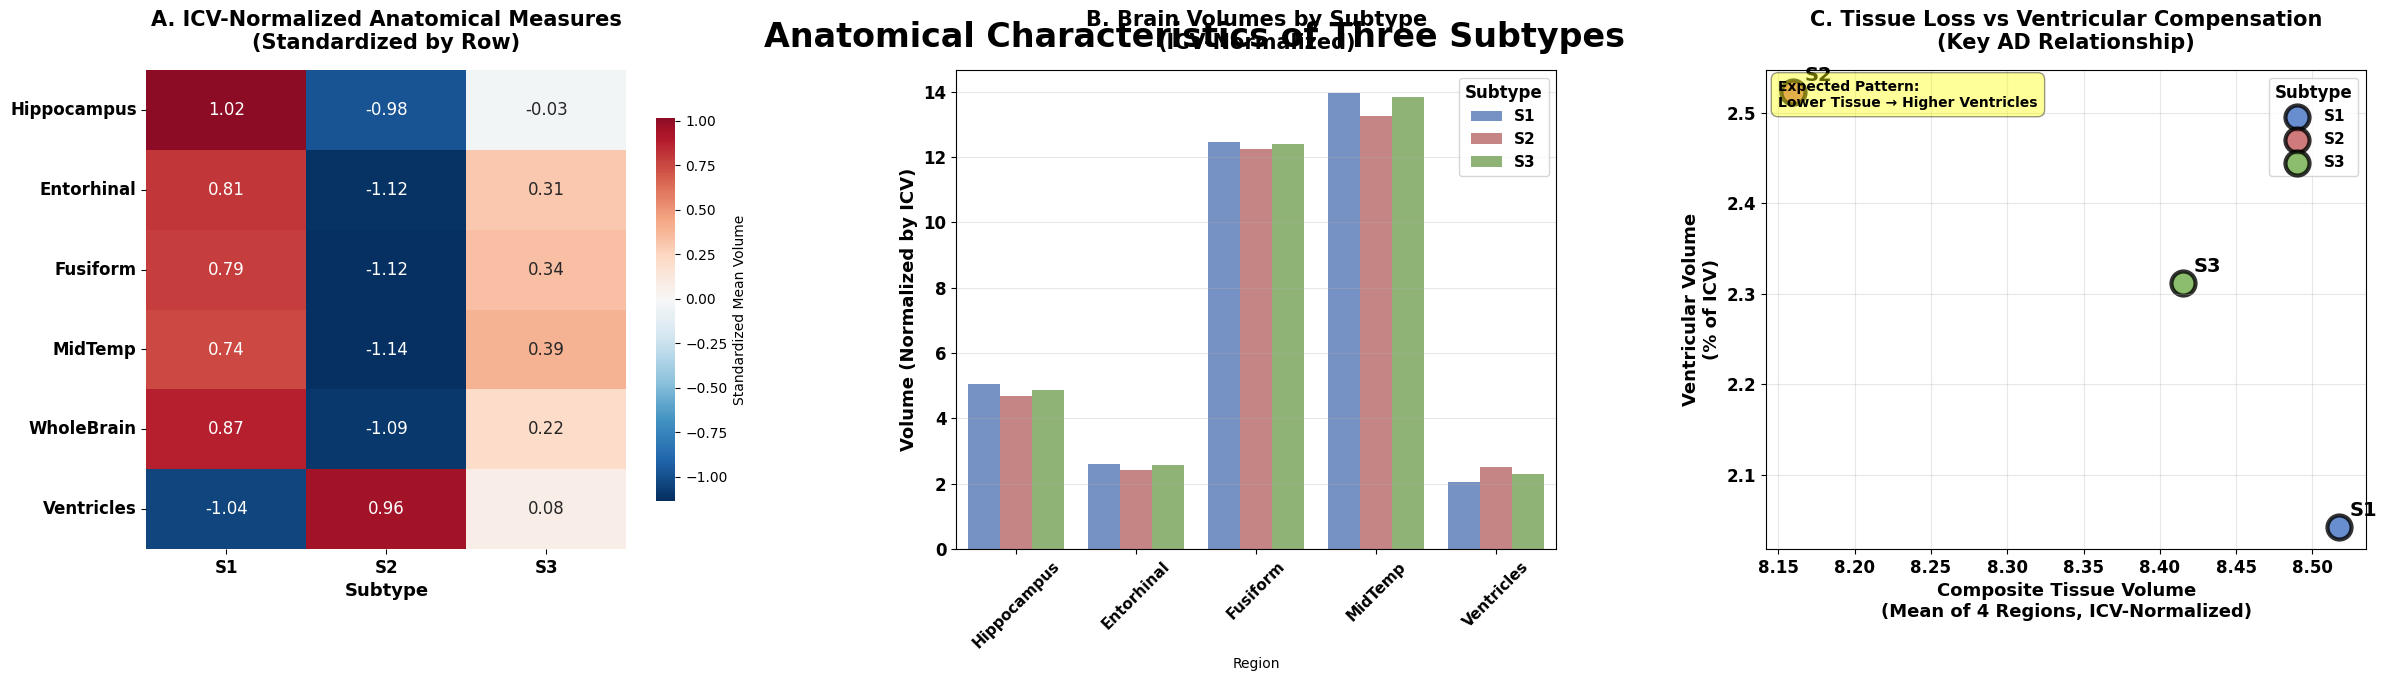


PUBLICATION-READY ANATOMICAL ANALYSIS
Plot A (Heatmap): Standardized patterns showing relative differences
Plot B (Bar Chart): Raw ICV-normalized volume comparisons
Plot C (Scatter): Tissue-ventricle relationship validating AD progression

Methodology: All brain volumes normalized by intracranial volume (ICV)
Standardization: Heatmap shows z-scores (row-wise standardization)


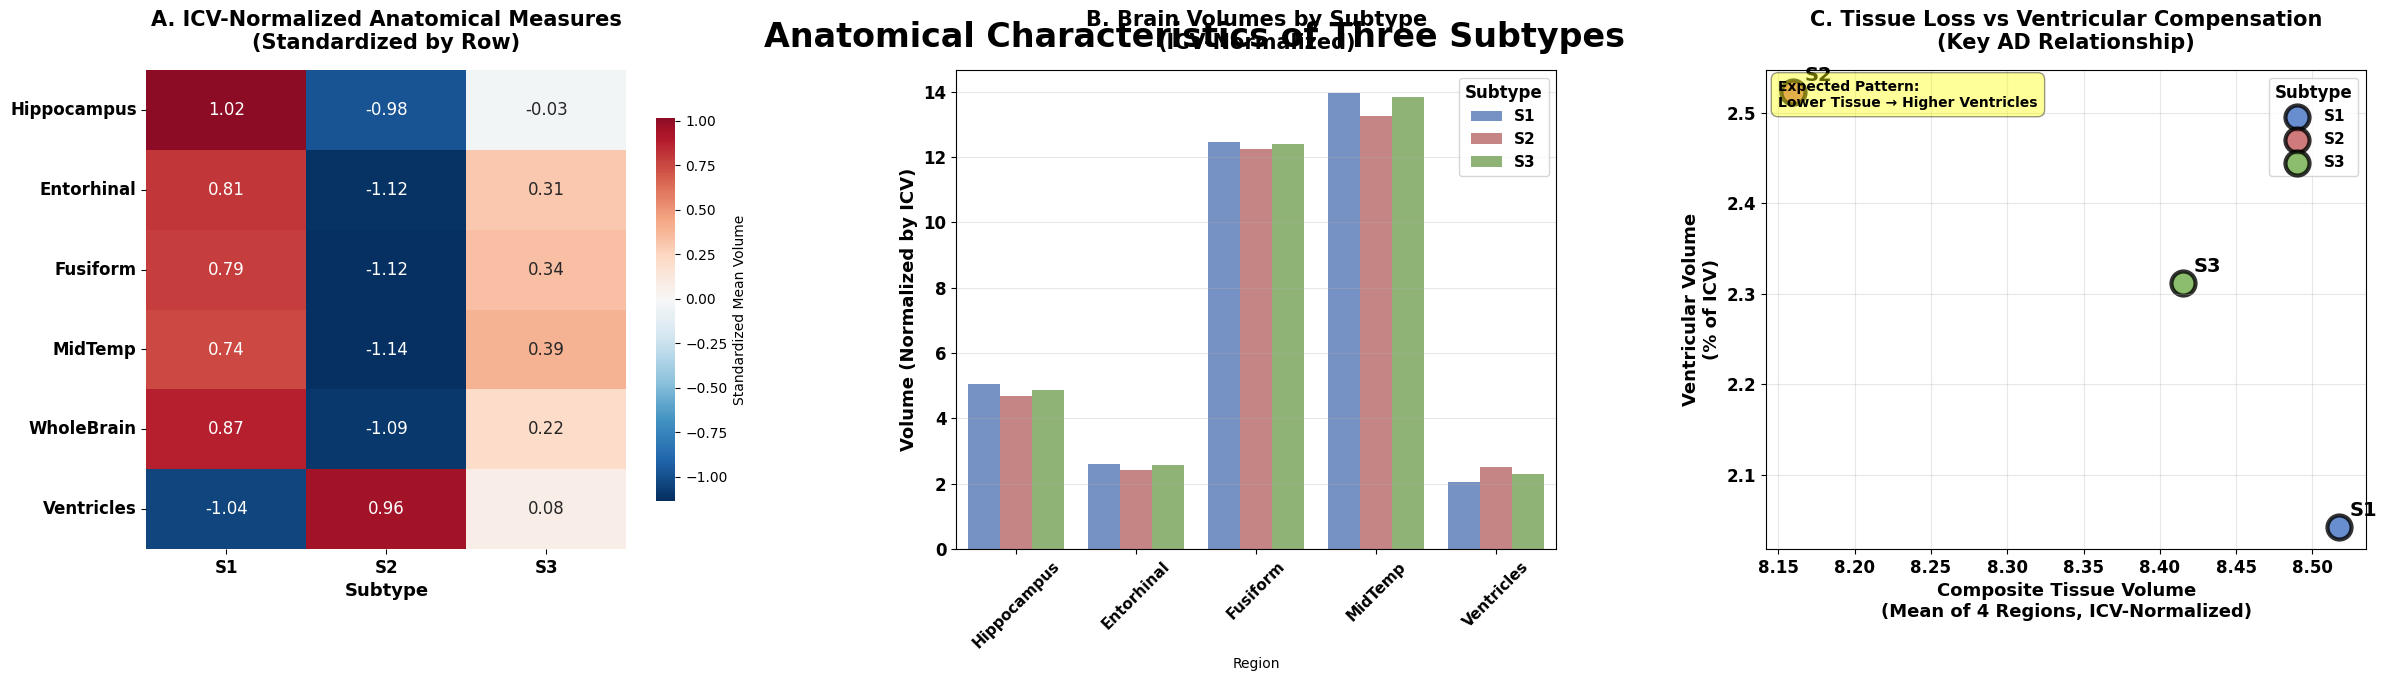


PLOT INTERPRETATIONS:
Plot 1 (Bar Chart): Raw volume differences between subtypes
Plot 2 (Scatter): Tissue-ventricle relationship (AD hallmark)
Plot 3 (Heatmap): Standardized patterns across regions

Note: All volumes already ICV-normalized (*_bl_norm variables)


In [70]:
# =============================================================================
# FINAL THREE ANATOMICAL PLOTS - CLEAN CODE
# Variables are already ICV-normalized (indicated by _bl_norm suffix)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# =============================================================================
# FINAL THREE ANATOMICAL PLOTS - PUBLICATION READY
# Variables are already ICV-normalized (indicated by _bl_norm suffix)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_three_anatomical_plots():
    """
    Create final 3-panel anatomical visualization for publication
    Plot 1: ICV-Normalized Heatmap (Standardized by Row)
    Plot 2: Raw volumes (bar chart)
    Plot 3: Tissue vs ventricles (scatter)
    """
    
    # Set up figure - 1 row, 3 columns with more space
    plt.style.use('default')
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))  # Increased height and width
    fig.suptitle('Anatomical Characteristics of Three Subtypes', 
                fontsize=24, fontweight='bold', y=0.95)  # Moved title higher
    
    # Assign axes
    ax1, ax2, ax3 = axes[0], axes[1], axes[2]
    
    # Define variables (already ICV-normalized)
    anatomical_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 
                      'MidTemp_bl_norm', 'Ventricles_pct']
    region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'Ventricles']
    
    # Colors for S1, S2, S3
    colors = ['#4472C4', '#C55A5A', '#70AD47']
    subtypes = ['S1', 'S2', 'S3']
    
    # =============================================================================
    # PLOT 1: ICV-Normalized Heatmap (Standardized by Row) - FIRST
    # =============================================================================
    
    # Include WholeBrain in heatmap for completeness
    heatmap_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 
                    'MidTemp_bl_norm', 'WholeBrain_bl_norm', 'Ventricles_pct']
    heatmap_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'WholeBrain', 'Ventricles']
    
    # Calculate means for heatmap
    heatmap_data = []
    for var in heatmap_vars:
        if var in df_anatomical.columns:
            row = []
            for subtype in ['S1', 'S2', 'S3']:
                mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
                row.append(mean_val)
            heatmap_data.append(row)
    
    if heatmap_data:
        heatmap_df = pd.DataFrame(heatmap_data, columns=['S1', 'S2', 'S3'], index=heatmap_labels)
        
        # Standardize each row (z-score normalization)
        heatmap_normalized = heatmap_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
        
        # Create heatmap with larger text
        sns.heatmap(heatmap_normalized, annot=True, cmap='RdBu_r', center=0, 
                    cbar_kws={'label': 'Standardized Mean Volume', 'shrink': 0.8}, 
                    ax=ax1, fmt='.2f', annot_kws={'fontsize': 12})
        
        ax1.set_title('A. ICV-Normalized Anatomical Measures\n(Standardized by Row)', 
                     fontweight='bold', fontsize=15, pad=15)
        ax1.set_xlabel('Subtype', fontweight='bold', fontsize=13)
        #ax1.set_ylabel('Brain Region', fontweight='bold', fontsize=13)
        
        # Make tick labels bold and larger
        ax1.tick_params(axis='x', labelsize=12, labelcolor='black')
        ax1.tick_params(axis='y', labelsize=12, labelcolor='black')
        
        # Make tick labels bold
        for label in ax1.get_xticklabels():
            label.set_fontweight('bold')
        for label in ax1.get_yticklabels():
            label.set_fontweight('bold')
        
        # Rotate y-axis labels for better readability
        ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    else:
        ax1.text(0.5, 0.5, 'Heatmap data not available', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=14)
    
    # =============================================================================
    # PLOT 2: Raw Volumes Bar Chart - SECOND
    # =============================================================================
    
    # Prepare data for grouped bar plot (excluding WholeBrain to avoid skewing)
    plot_data = []
    
    for var, label in zip(anatomical_vars, region_labels):
        if var in df_anatomical.columns:
            for subtype in subtypes:
                mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
                plot_data.append({
                    'Region': label,
                    'Subtype': subtype, 
                    'Volume': mean_val
                })
    
    # Create DataFrame and plot
    plot_df = pd.DataFrame(plot_data)
    
    sns.barplot(data=plot_df, x='Region', y='Volume', hue='Subtype', 
               palette=colors, ax=ax2, alpha=0.8)
    
    ax2.set_title('B. Brain Volumes by Subtype\n(ICV-Normalized)', 
                 fontweight='bold', fontsize=15, pad=15)
    #ax2.set_xlabel('Brain Regions', fontweight='bold', fontsize=13)
    ax2.set_ylabel('Volume (Normalized by ICV)', fontweight='bold', fontsize=13)
    
    # Make tick labels bold and larger
    ax2.tick_params(axis='x', rotation=45, labelsize=11)
    ax2.tick_params(axis='y', labelsize=12)
    
    # Make tick labels bold
    for label in ax2.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax2.get_yticklabels():
        label.set_fontweight('bold')
    
    # Bold legend
    legend2 = ax2.legend(title='Subtype', fontsize=11, title_fontsize=12, loc='upper right')
    legend2.get_title().set_fontweight('bold')
    for text in legend2.get_texts():
        text.set_fontweight('bold')
    
    ax2.grid(True, alpha=0.3, axis='y')
    
    # =============================================================================
    # PLOT 3: Tissue vs Ventricles Scatter - THIRD
    # =============================================================================
    
    # Calculate composite tissue volume (average of 4 brain regions)
    tissue_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm', 'MidTemp_bl_norm']
    
    tissue_means = []
    vent_means = []
    
    for subtype in subtypes:
        subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype]
        
        # Average tissue volume across 4 regions
        tissue_vals = []
        for var in tissue_vars:
            if var in df_anatomical.columns:
                tissue_vals.append(subtype_data[var].mean())
        
        tissue_mean = np.mean(tissue_vals) if tissue_vals else 0
        tissue_means.append(tissue_mean)
        
        # Ventricular volume
        if 'Ventricles_pct' in df_anatomical.columns:
            vent_mean = subtype_data['Ventricles_pct'].mean()
            vent_means.append(vent_mean)
        else:
            vent_means.append(0)
    
    # Create scatter plot with larger markers
    for i, subtype in enumerate(subtypes):
        ax3.scatter(tissue_means[i], vent_means[i], 
                   s=300, c=colors[i], alpha=0.8, 
                   edgecolors='black', linewidth=3, label=subtype)
        
        # Add subtype labels with larger font
        ax3.annotate(subtype, (tissue_means[i], vent_means[i]), 
                    xytext=(8, 8), textcoords='offset points',
                    fontweight='bold', fontsize=14)
    
    ax3.set_xlabel('Composite Tissue Volume\n(Mean of 4 Regions, ICV-Normalized)', 
                  fontweight='bold', fontsize=13)
    ax3.set_ylabel('Ventricular Volume\n(% of ICV)', fontweight='bold', fontsize=13)
    ax3.set_title('C. Tissue Loss vs Ventricular Compensation\n(Key AD Relationship)', 
                 fontweight='bold', fontsize=15, pad=15)
    
    # Make tick labels bold and larger
    ax3.tick_params(axis='x', labelsize=12)
    ax3.tick_params(axis='y', labelsize=12)
    
    # Make tick labels bold
    for label in ax3.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax3.get_yticklabels():
        label.set_fontweight('bold')
    
    ax3.grid(True, alpha=0.3)
    
    # Bold legend
    legend3 = ax3.legend(fontsize=11, title='Subtype', title_fontsize=12)
    legend3.get_title().set_fontweight('bold')
    for text in legend3.get_texts():
        text.set_fontweight('bold')
    
    # Add interpretation note with larger text
    ax3.text(0.02, 0.98, 'Expected Pattern:\nLower Tissue → Higher Ventricles', 
            transform=ax3.transAxes, va='top', ha='left',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.4),
            fontsize=10, fontweight='bold')
    
    # Final layout adjustments
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, wspace=0.35)  # More space and lower top margin
    plt.show()
    
    return fig

# =============================================================================
# USAGE
# =============================================================================

# Execute the function
fig = create_three_anatomical_plots()

print("\n" + "="*80)
print("PUBLICATION-READY ANATOMICAL ANALYSIS")
print("="*80)
print("Plot A (Heatmap): Standardized patterns showing relative differences")
print("Plot B (Bar Chart): Raw ICV-normalized volume comparisons")  
print("Plot C (Scatter): Tissue-ventricle relationship validating AD progression")
print("\nMethodology: All brain volumes normalized by intracranial volume (ICV)")
print("Standardization: Heatmap shows z-scores (row-wise standardization)")
print("="*80)

# =============================================================================
# USAGE
# =============================================================================

# Execute the function
fig = create_three_anatomical_plots()

print("\n" + "="*60)
print("PLOT INTERPRETATIONS:")
print("="*60)
print("Plot 1 (Bar Chart): Raw volume differences between subtypes")
print("Plot 2 (Scatter): Tissue-ventricle relationship (AD hallmark)")  
print("Plot 3 (Heatmap): Standardized patterns across regions")
print("\nNote: All volumes already ICV-normalized (*_bl_norm variables)")
print("="*60)

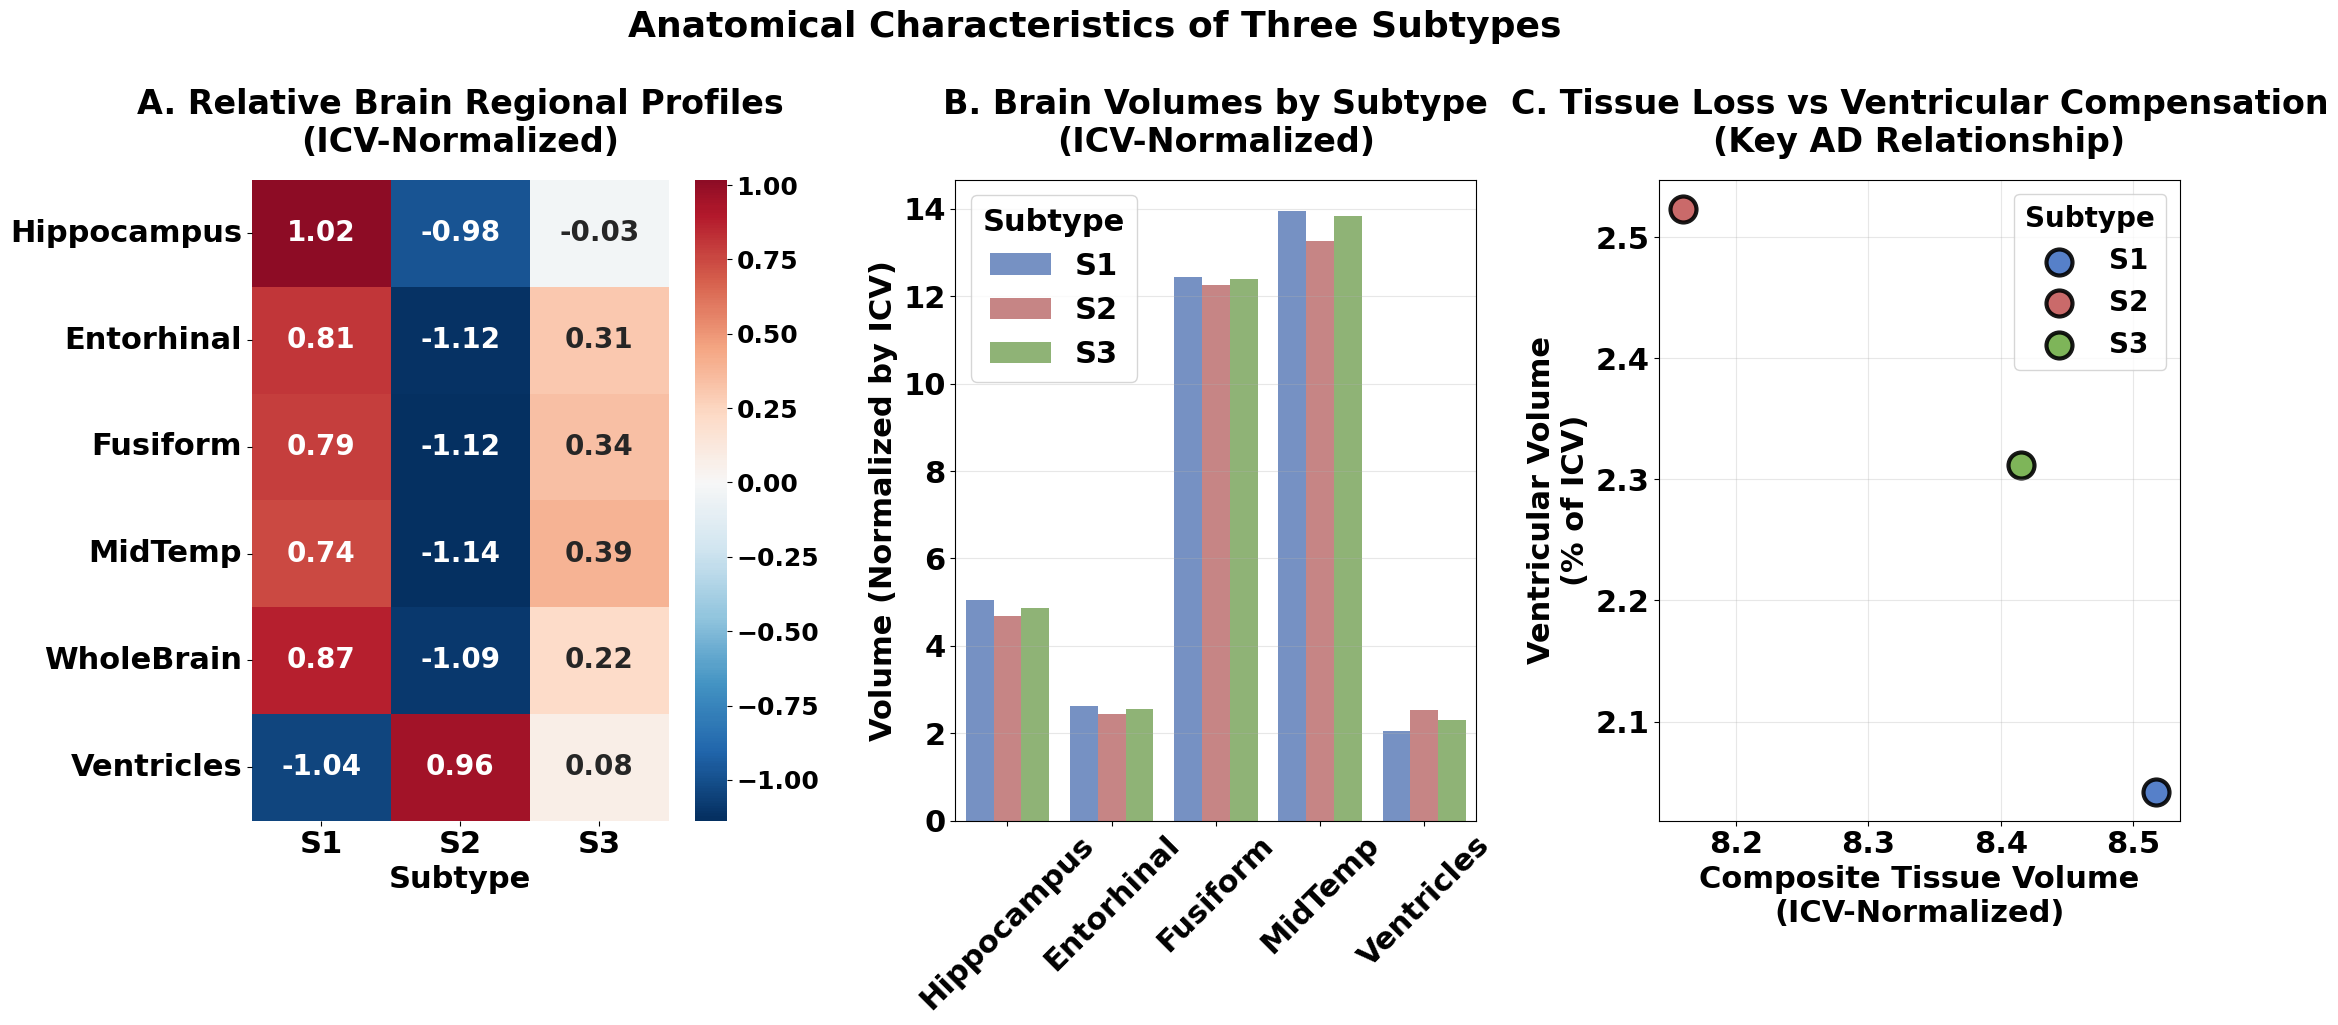

In [9]:
def create_three_anatomical_plots():
    plt.style.use('default')
    fig, axes = plt.subplots(1, 3, figsize=(22, 10))
    fig.suptitle('Anatomical Characteristics of Three Subtypes',
                 fontsize=26, fontweight='bold', y=1.02)  # Moved higher to avoid overlap

    ax1, ax2, ax3 = axes[0], axes[1], axes[2]

    anatomical_vars = ['Hippocampus_bl_norm', 'Entorhinal_bl_norm', 'Fusiform_bl_norm',
                       'MidTemp_bl_norm', 'Ventricles_pct']
    region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'Ventricles']
    heatmap_vars = anatomical_vars[:4] + ['WholeBrain_bl_norm', 'Ventricles_pct']
    heatmap_labels = region_labels[:4] + ['WholeBrain', 'Ventricles']
    colors = ['#4472C4', '#C55A5A', '#70AD47']
    subtypes = ['S1', 'S2', 'S3']

    # ------------------ PLOT 1: Heatmap ------------------
    heatmap_data = []
    for var in heatmap_vars:
        if var in df_anatomical.columns:
            row = []
            for subtype in subtypes:
                row.append(df_anatomical[df_anatomical['Subtype'] == subtype][var].mean())
            heatmap_data.append(row)

    if heatmap_data:
        heatmap_df = pd.DataFrame(heatmap_data, columns=subtypes, index=heatmap_labels)
        heatmap_normalized = heatmap_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
        # Draw heatmap
        # Draw the heatmap
        heatmap = sns.heatmap(
            heatmap_normalized,
            annot=True,
            cmap='RdBu_r',
            center=0,
            ax=ax1,
            fmt='.2f',
            annot_kws={'fontsize': 20}
        )

        # Bold annotation texts
        for text in ax1.texts:
            text.set_fontweight('bold')

        # Make the colorbar label bold
        colorbar = heatmap.collections[0].colorbar
        #colorbar.set_label('Standardized Mean Volume', weight='bold', fontsize=19)

        # (Optional) bolden colorbar tick labels
        colorbar.ax.tick_params(labelsize=18)
        for label in colorbar.ax.get_yticklabels():
            label.set_fontweight('bold')


        ax1.set_title('A. Relative Brain Regional Profiles\n(ICV-Normalized)',
                      fontweight='bold', fontsize=24, pad=20)
        ax1.set_xlabel('Subtype', fontweight='bold', fontsize=22)
        #ax1.set_ylabel('Brain Region', fontweight='bold', fontsize=20)
        ax1.tick_params(axis='x', labelsize=22)
        ax1.tick_params(axis='y', labelsize=22)
        for label in ax1.get_xticklabels() + ax1.get_yticklabels():
            label.set_fontweight('bold')
        ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    else:
        ax1.text(0.5, 0.5, 'Heatmap data not available', ha='center', va='center',
                 transform=ax1.transAxes, fontsize=18, fontweight='bold')
    # ------------------ PLOT 2: Bar Plot ------------------
    plot_data = []
    for var, label in zip(anatomical_vars, region_labels):
        if var in df_anatomical.columns:
            for subtype in subtypes:
                mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
                plot_data.append({'Region': label, 'Subtype': subtype, 'Volume': mean_val})
    plot_df = pd.DataFrame(plot_data)

    sns.barplot(data=plot_df, x='Region', y='Volume', hue='Subtype',
                palette=colors, ax=ax2, alpha=0.8)

    ax2.set_title('B. Brain Volumes by Subtype\n(ICV-Normalized)',
                  fontweight='bold', fontsize=24, pad=20)
    #ax2.set_xlabel('Brain Regions', fontweight='bold', fontsize=20)
    ax2.set_ylabel('Volume (Normalized by ICV)', fontweight='bold', fontsize=22)
    ax2.tick_params(axis='x', rotation=45, labelsize=22)
    ax2.tick_params(axis='y', labelsize=22)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    legend2 = ax2.legend(title='Subtype', fontsize=22, title_fontsize=22, loc='upper left')
    legend2.get_title().set_fontweight('bold')
    for text in legend2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xlabel('', fontsize=0)  # Removes bottom label


    # ------------------ PLOT 3: Scatter ------------------
    tissue_vars = anatomical_vars[:4]
    tissue_means, vent_means = [], []

    for subtype in subtypes:
        subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype]
        tissue_vals = [subtype_data[var].mean() for var in tissue_vars if var in df_anatomical.columns]
        tissue_means.append(np.mean(tissue_vals))
        vent_means.append(subtype_data['Ventricles_pct'].mean() if 'Ventricles_pct' in df_anatomical.columns else 0)

    for i, subtype in enumerate(subtypes):
        ax3.scatter(tissue_means[i], vent_means[i],
                    s=350, c=colors[i], alpha=0.9,
                    edgecolors='black', linewidth=3, label=subtype)


    ax3.set_xlabel('Composite Tissue Volume\n(ICV-Normalized)',
                   fontweight='bold', fontsize=22)
    ax3.set_ylabel('Ventricular Volume\n(% of ICV)', fontweight='bold', fontsize=22)
    ax3.set_title('C. Tissue Loss vs Ventricular Compensation\n(Key AD Relationship)',
                  fontweight='bold', fontsize=24, pad=20)
    ax3.tick_params(axis='x', labelsize=22)
    ax3.tick_params(axis='y', labelsize=22)
    for label in ax3.get_xticklabels() + ax3.get_yticklabels():
        label.set_fontweight('bold')
    ax3.grid(True, alpha=0.3)
    # Add legend to plot 3 (scatter)
    legend3 = ax3.legend(title='Subtype', fontsize=20, title_fontsize=20, loc='upper right')
    legend3.get_title().set_fontweight('bold')
    for text in legend3.get_texts():
        text.set_fontweight('bold')


        # Final layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.35)

    # Save to PDF
    fig.savefig("anatomical_subtypes_plot.pdf", format='pdf', bbox_inches='tight')

    plt.show()
    return fig


fig = create_three_anatomical_plots()



In [65]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Anatomical Variables
anatomical_vars = [
    'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl',
    'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl'
]

# Variables that need ICV normalization (exclude ICV itself and Ventricles)
normalize_vars = ['Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl']

# Anatomical variable display names
anatomical_vars_dict = {
    'Ventricles_bl': 'Ventricles Volume',
    'Hippocampus_bl': 'Hippocampus Volume',
    'WholeBrain_bl': 'Whole Brain Volume',
    'Entorhinal_bl': 'Entorhinal Cortex Volume',
    'Fusiform_bl': 'Fusiform Gyrus Volume',
    'MidTemp_bl': 'Middle Temporal Gyrus Volume',
    'ICV_bl': 'Intracranial Volume',
    'Hippocampus_bl_norm': 'Hippocampus Volume (ICV-normalized)',
    'WholeBrain_bl_norm': 'Whole Brain Volume (ICV-normalized)',
    'Entorhinal_bl_norm': 'Entorhinal Cortex Volume (ICV-normalized)',
    'Fusiform_bl_norm': 'Fusiform Gyrus Volume (ICV-normalized)',
    'MidTemp_bl_norm': 'Middle Temporal Gyrus Volume (ICV-normalized)'
}

# Use existing dataframe with anatomical data
df_anatomical = df_demo_predicted.copy()

# Remove any rows with missing anatomical data
df_anatomical = df_anatomical.dropna(subset=anatomical_vars)

print("Filtered anatomical dataset shape:", df_anatomical.shape)

# Calculate ICV-normalized volumes (multiply by 1000 for better readability)
for var in normalize_vars:
    df_anatomical[f'{var}_norm'] = (df_anatomical[var] / df_anatomical['ICV_bl']) * 1000

# Use only normalized volumes + Ventricles (which doesn't need normalization) + ICV for reference
analysis_vars = ['Ventricles_bl', 'ICV_bl'] + [f'{var}_norm' for var in normalize_vars]

# =============================================================================
# ANATOMICAL PAIRWISE COMPARISONS WITH FDR CORRECTION
# =============================================================================

def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    pooled_std = np.sqrt(((n1-1)*np.var(group1, ddof=1) + (n2-1)*np.var(group2, ddof=1)) / (n1+n2-2))
    return (mean1 - mean2) / pooled_std

def interpret_effect_size(d):
    """Interpret Cohen's d effect size"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    else:
        return "Large"

def interpret_direction(mean1, mean2, comparison):
    """Interpret which group is higher"""
    if mean1 > mean2:
        return f"{comparison.split(' vs ')[0]} > {comparison.split(' vs ')[1]}"
    else:
        return f"{comparison.split(' vs ')[1]} > {comparison.split(' vs ')[0]}"

def get_anatomical_domain(var_name):
    """Classify anatomical variable by domain"""
    if '_norm' in var_name:
        return 'ICV-Normalized Volume'
    elif var_name in ['Ventricles_bl']:
        return 'Ventricular Volume'
    elif var_name in ['ICV_bl']:
        return 'Total Intracranial Volume'
    else:
        return 'Raw Volume'

# Prepare results storage
results = []
all_pvalues = []

# Define comparisons
comparisons = [
    ('S1', 'S2', 'S1 vs S2'),
    ('S1', 'S3', 'S1 vs S3'), 
    ('S2', 'S3', 'S2 vs S3')
]

print("="*100)
print("COMPREHENSIVE PAIRWISE ANATOMICAL COMPARISONS")
print("="*100)

# Perform all pairwise comparisons for anatomical measures
for var in analysis_vars:
    for group1_name, group2_name, comparison_name in comparisons:
        # Extract data for both groups
        group1_data = df_anatomical[df_anatomical['Subtype'] == group1_name][var]
        group2_data = df_anatomical[df_anatomical['Subtype'] == group2_name][var]
        
        # Remove any NaN values
        group1_clean = group1_data.dropna()
        group2_clean = group2_data.dropna()
        
        # Perform t-test
        t_stat, p_val = ttest_ind(group1_clean, group2_clean, equal_var=False)  # Welch's t-test
        
        # Calculate descriptive statistics
        mean1, mean2 = np.mean(group1_clean), np.mean(group2_clean)
        std1, std2 = np.std(group1_clean, ddof=1), np.std(group2_clean, ddof=1)
        n1, n2 = len(group1_clean), len(group2_clean)
        
        # Calculate effect size (Cohen's d)
        cohens_d = calculate_cohens_d(group1_clean, group2_clean)
        
        # Calculate 95% confidence interval for the difference
        diff_mean = mean1 - mean2
        pooled_se = np.sqrt((std1**2/n1) + (std2**2/n2))
        df_welch = ((std1**2/n1) + (std2**2/n2))**2 / ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))
        t_critical = stats.t.ppf(0.975, df_welch)
        ci_lower = diff_mean - t_critical * pooled_se
        ci_upper = diff_mean + t_critical * pooled_se
        
        # Get display name
        display_name = anatomical_vars_dict.get(var, var.replace('_bl', ''))
        
        # Store results
        result = {
            'Measure': display_name,
            'Variable': var,
            'Domain': get_anatomical_domain(var),
            'Comparison': comparison_name,
            'Group1': group1_name,
            'Group2': group2_name,
            'N1': n1,
            'N2': n2,
            'Mean1': mean1,
            'SD1': std1,
            'Mean2': mean2,
            'SD2': std2,
            'Mean_Diff': diff_mean,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            't_statistic': t_stat,
            'df': df_welch,
            'p_value': p_val,
            'Cohens_d': cohens_d,
            'Effect_Size': interpret_effect_size(cohens_d),
            'Direction': interpret_direction(mean1, mean2, comparison_name)
        }
        
        results.append(result)
        all_pvalues.append(p_val)

# Apply FDR correction
fdr_corrected = multipletests(all_pvalues, method='fdr_bh')[1]

# Add FDR corrected p-values to results
for i, result in enumerate(results):
    result['p_FDR'] = fdr_corrected[i]
    result['Significant_FDR'] = 'Yes' if fdr_corrected[i] < 0.05 else 'No'
    result['Significance_Level'] = '***' if fdr_corrected[i] < 0.001 else '**' if fdr_corrected[i] < 0.01 else '*' if fdr_corrected[i] < 0.05 else 'ns'

# Convert to DataFrame
results_df = pd.DataFrame(results)

# =============================================================================
# SUMMARY TABLES
# =============================================================================

print("\n" + "="*100)
print("TABLE 1: DETAILED PAIRWISE ANATOMICAL COMPARISON RESULTS")
print("="*100)

# Create detailed table with domain grouping
detailed_table = results_df[['Measure', 'Domain', 'Comparison', 'N1', 'N2', 'Mean1', 'SD1', 'Mean2', 'SD2', 
                            'Mean_Diff', 'CI_Lower', 'CI_Upper', 't_statistic', 'df', 'p_value', 'p_FDR', 
                            'Cohens_d', 'Effect_Size', 'Direction', 'Significance_Level']].round(4)

print(detailed_table.to_string(index=False, max_colwidth=20))

print("\n" + "="*100)
print("TABLE 2: SIMPLIFIED SUMMARY TABLE BY DOMAIN")
print("="*100)

# Create simplified summary table grouped by domain
summary_table = results_df[['Measure', 'Domain', 'Comparison', 'Mean_Diff', 't_statistic', 'p_value', 'p_FDR', 
                           'Cohens_d', 'Effect_Size', 'Direction', 'Significance_Level']].round(3)

# Sort by domain and measure for better organization
summary_table_sorted = summary_table.sort_values(['Domain', 'Measure', 'Comparison'])
print(summary_table_sorted.to_string(index=False))

print("\n" + "="*100)
print("TABLE 3: SIGNIFICANT RESULTS ONLY (p_FDR < 0.05)")
print("="*100)

# Filter significant results
significant_results = results_df[results_df['p_FDR'] < 0.05]

if len(significant_results) > 0:
    sig_table = significant_results[['Measure', 'Domain', 'Comparison', 'Mean_Diff', 't_statistic', 
                                   'p_FDR', 'Cohens_d', 'Effect_Size', 'Direction']].round(3)
    print(sig_table.to_string(index=False))
else:
    print("No anatomical comparisons survived FDR correction (p_FDR < 0.05)")

print("\n" + "="*100)
print("TABLE 4: EFFECT SIZES BY DOMAIN AND COMPARISON")
print("="*100)

# Create effect size summary by domain
effect_size_summary = []
for domain in ['ICV-Normalized Volume', 'Ventricular Volume', 'Total Intracranial Volume']:
    domain_data = results_df[results_df['Domain'] == domain]
    if len(domain_data) > 0:
        for comparison in ['S1 vs S2', 'S1 vs S3', 'S2 vs S3']:
            comp_data = domain_data[domain_data['Comparison'] == comparison]
            if len(comp_data) > 0:
                mean_effect = comp_data['Cohens_d'].mean()
                large_effects = sum(abs(comp_data['Cohens_d']) > 0.8)
                medium_effects = sum((abs(comp_data['Cohens_d']) > 0.5) & (abs(comp_data['Cohens_d']) <= 0.8))
                small_effects = sum((abs(comp_data['Cohens_d']) > 0.2) & (abs(comp_data['Cohens_d']) <= 0.5))
                
                effect_size_summary.append({
                    'Domain': domain,
                    'Comparison': comparison,
                    'Mean_Effect_Size': mean_effect,
                    'Large_Effects': large_effects,
                    'Medium_Effects': medium_effects,
                    'Small_Effects': small_effects,
                    'Total_Measures': len(comp_data)
                })

effect_summary_df = pd.DataFrame(effect_size_summary)
print(effect_summary_df.round(3).to_string(index=False))

print("\n" + "="*100)
print("TABLE 5: STATISTICAL SUMMARY")
print("="*100)

# Summary statistics
total_comparisons = len(results_df)
significant_uncorrected = sum(results_df['p_value'] < 0.05)
significant_fdr = sum(results_df['p_FDR'] < 0.05)
large_effects = sum(abs(results_df['Cohens_d']) > 0.8)
medium_effects = sum((abs(results_df['Cohens_d']) > 0.5) & (abs(results_df['Cohens_d']) <= 0.8))
small_effects = sum((abs(results_df['Cohens_d']) > 0.2) & (abs(results_df['Cohens_d']) <= 0.5))

print(f"Total anatomical comparisons: {total_comparisons}")
print(f"Significant before FDR correction (p < 0.05): {significant_uncorrected}/{total_comparisons} ({significant_uncorrected/total_comparisons*100:.1f}%)")
print(f"Significant after FDR correction (p_FDR < 0.05): {significant_fdr}/{total_comparisons} ({significant_fdr/total_comparisons*100:.1f}%)")
print(f"Large effect sizes (|d| > 0.8): {large_effects}/{total_comparisons} ({large_effects/total_comparisons*100:.1f}%)")
print(f"Medium effect sizes (0.5 < |d| ≤ 0.8): {medium_effects}/{total_comparisons} ({medium_effects/total_comparisons*100:.1f}%)")
print(f"Small effect sizes (0.2 < |d| ≤ 0.5): {small_effects}/{total_comparisons} ({small_effects/total_comparisons*100:.1f}%)")

# =============================================================================
# ANATOMICAL PATTERNS ANALYSIS
# =============================================================================

print("\n" + "="*100)
print("TABLE 6: ANATOMICAL PATTERNS ANALYSIS")
print("="*100)

# Analyze directional patterns by anatomical measure
anatomical_patterns = []

# Get unique measures
unique_measures = results_df['Variable'].unique()

for measure in unique_measures:
    measure_results = results_df[results_df['Variable'] == measure]
    
    # Extract means for each subtype
    s1_means = []
    s2_means = []
    s3_means = []
    
    for _, row in measure_results.iterrows():
        if row['Group1'] == 'S1':
            s1_means.append(row['Mean1'])
            if row['Group2'] == 'S2':
                s2_means.append(row['Mean2'])
            elif row['Group2'] == 'S3':
                s3_means.append(row['Mean2'])
        elif row['Group1'] == 'S2':
            s2_means.append(row['Mean1'])
            s3_means.append(row['Mean2'])
    
    # Get unique means
    s1_mean = s1_means[0] if s1_means else None
    s2_mean = s2_means[0] if s2_means else None
    s3_mean = s3_means[0] if s3_means else None
    
    if all(x is not None for x in [s1_mean, s2_mean, s3_mean]):
        # Determine pattern
        means_dict = {'S1': s1_mean, 'S2': s2_mean, 'S3': s3_mean}
        sorted_means = sorted(means_dict.items(), key=lambda x: x[1], reverse=True)
        pattern = ' > '.join([item[0] for item in sorted_means])
        
        # Expected pattern: For most brain volumes, expect S1 (low tau) > S3 > S2 (high tau)
        # For ventricles, expect the opposite: S2 > S3 > S1 (atrophy pattern)
        if 'Ventricles' in measure:
            expected_pattern = 'S2 > S3 > S1'  # Larger ventricles in high tau
        else:
            expected_pattern = 'S1 > S3 > S2'  # Larger volumes in low tau
        
        matches_expected = pattern == expected_pattern
        
        # Get domain and display name
        domain = get_anatomical_domain(measure)
        display_name = anatomical_vars_dict.get(measure, measure.replace('_bl', ''))
        
        anatomical_patterns.append({
            'Measure': display_name,
            'Variable': measure,
            'Domain': domain,
            'S1_Mean': s1_mean,
            'S2_Mean': s2_mean,
            'S3_Mean': s3_mean,
            'Observed_Pattern': pattern,
            'Expected_Pattern': expected_pattern,
            'Matches_Expected': 'Yes' if matches_expected else 'No'
        })

anatomical_patterns_df = pd.DataFrame(anatomical_patterns)
print(anatomical_patterns_df.round(3).to_string(index=False))

# Calculate pattern matching by domain
print("\n" + "="*50)
print("PATTERN MATCHING SUMMARY BY DOMAIN")
print("="*50)

for domain in ['ICV-Normalized Volume', 'Ventricular Volume', 'Total Intracranial Volume']:
    domain_subset = anatomical_patterns_df[anatomical_patterns_df['Domain'] == domain]
    if len(domain_subset) > 0:
        matches = sum(domain_subset['Matches_Expected'] == 'Yes')
        total = len(domain_subset)
        print(f"{domain}: {matches}/{total} ({matches/total*100:.1f}%) match expected pattern")

# =============================================================================
# EXPORT ANATOMICAL RESULTS
# =============================================================================

print("\n" + "="*100)
print("EXPORTING ANATOMICAL RESULTS TO CSV FILES")
print("="*100)

# Export detailed results
results_df.round(4).to_csv('anatomical_pairwise_detailed.csv', index=False)
print("✓ Detailed anatomical results exported to: anatomical_pairwise_detailed.csv")

# Export summary table
summary_table_sorted.to_csv('anatomical_pairwise_summary.csv', index=False)
print("✓ Summary anatomical results exported to: anatomical_pairwise_summary.csv")

# Export significant results only
if len(significant_results) > 0:
    significant_results.round(4).to_csv('anatomical_pairwise_significant.csv', index=False)
    print("✓ Significant anatomical results exported to: anatomical_pairwise_significant.csv")

# Export anatomical patterns analysis
anatomical_patterns_df.round(3).to_csv('anatomical_patterns.csv', index=False)
print("✓ Anatomical patterns exported to: anatomical_patterns.csv")

# Export effect size summary
effect_summary_df.round(3).to_csv('anatomical_effect_size_summary.csv', index=False)
print("✓ Anatomical effect size summary exported to: anatomical_effect_size_summary.csv")

# =============================================================================
# DESCRIPTIVE STATISTICS BY SUBTYPE
# =============================================================================

print("\n" + "="*100)
print("TABLE 7: DESCRIPTIVE STATISTICS BY SUBTYPE")
print("="*100)

# Calculate descriptive statistics for each anatomical measure by subtype
descriptive_stats = []

for var in analysis_vars:
    display_name = anatomical_vars_dict.get(var, var.replace('_bl', ''))
    domain = get_anatomical_domain(var)
    
    for subtype in ['S1', 'S2', 'S3']:
        subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype][var].dropna()
        
        if len(subtype_data) > 0:
            descriptive_stats.append({
                'Measure': display_name,
                'Variable': var,
                'Domain': domain,
                'Subtype': subtype,
                'N': len(subtype_data),
                'Mean': np.mean(subtype_data),
                'SD': np.std(subtype_data, ddof=1),
                'Median': np.median(subtype_data),
                'Min': np.min(subtype_data),
                'Max': np.max(subtype_data),
                'Q25': np.percentile(subtype_data, 25),
                'Q75': np.percentile(subtype_data, 75)
            })

descriptive_df = pd.DataFrame(descriptive_stats)
descriptive_summary = descriptive_df[['Measure', 'Domain', 'Subtype', 'N', 'Mean', 'SD', 'Median']].round(3)
print(descriptive_summary.to_string(index=False))

# Export descriptive statistics
descriptive_df.round(4).to_csv('anatomical_descriptives.csv', index=False)
print("\n✓ Anatomical descriptive statistics exported to: anatomical_descriptives.csv")

print("\n" + "="*100)
print("ANATOMICAL ANALYSIS COMPLETE - ALL TABLES GENERATED")
print("="*100)

Filtered anatomical dataset shape: (271, 122)
COMPREHENSIVE PAIRWISE ANATOMICAL COMPARISONS

TABLE 1: DETAILED PAIRWISE ANATOMICAL COMPARISON RESULTS
             Measure               Domain Comparison  N1  N2        Mean1         SD1        Mean2         SD2  Mean_Diff    CI_Lower   CI_Upper  t_statistic      df  p_value  p_FDR  Cohens_d Effect_Size Direction Significance_Level
   Ventricles Volume   Ventricular Volume   S1 vs S2 184  33   30946.7870  17221.3670   38472.3212  18708.6193 -7525.5343 -14578.2111  -472.8574      -2.1529 42.2941   0.0371 0.1804   -0.4312       Small   S2 > S1                 ns
   Ventricles Volume   Ventricular Volume   S1 vs S3 184  54   30946.7870  17221.3670   34703.2648  20469.8252 -3756.4779  -9853.0598  2340.1041      -1.2271 76.3513   0.2236 0.4879   -0.2087       Small   S3 > S1                 ns
   Ventricles Volume   Ventricular Volume   S2 vs S3  33  54   38472.3212  18708.6193   34703.2648  20469.8252  3769.0564  -4772.9975 12311.1103       

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# ANALYZE ANATOMICAL DATA - ICV NORMALIZATION & Z-SCORE NECESSITY
# =============================================================================

print("="*80)
print("ANATOMICAL DATA ANALYSIS - ICV & NORMALIZATION CHECK")
print("="*80)

# Define anatomical measures - checking DEFAULT variables (no _norm suffix)
anatomical_vars = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'Ventricles', 'WholeBrain']
region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'Ventricles', 'WholeBrain']

# Also check if ICV variable exists
icv_vars_to_check = ['ICV', 'icv', 'Intracranial', 'intracranial_volume']

print("\n1. CHECK: ARE DEFAULT VARIABLES ALREADY ICV-NORMALIZED?")
print("-" * 60)

# Check if ICV variable exists
icv_found = False
for icv_var in icv_vars_to_check:
    if icv_var in df_anatomical.columns:
        print(f"✓ Found ICV variable: {icv_var}")
        icv_found = True
        break

if not icv_found:
    print("✗ No obvious ICV variable found")

# Check the default anatomical variables
print(f"\nChecking DEFAULT brain region variables (no _norm suffix):")
for var, label in zip(anatomical_vars, region_labels):
    if var in df_anatomical.columns:
        print(f"✓ {label:15} : {var}")
    else:
        print(f"✗ {label:15} : {var} - NOT FOUND")

# Critical test: Check if volumes correlate with head size
if icv_found and any(var in df_anatomical.columns for var in anatomical_vars):
    print(f"\n🔍 TESTING: Are volumes already ICV-normalized?")
    
    # Get first available brain region and ICV
    test_region = None
    icv_var = None
    
    for var in anatomical_vars:
        if var in df_anatomical.columns:
            test_region = var
            break
    
    for var in icv_vars_to_check:
        if var in df_anatomical.columns:
            icv_var = var
            break
    
    if test_region and icv_var:
        # Calculate correlation between brain region and ICV
        correlation = df_anatomical[test_region].corr(df_anatomical[icv_var])
        print(f"  • Correlation between {test_region} and {icv_var}: {correlation:.3f}")
        
        if abs(correlation) > 0.5:
            print(f"  ❗ HIGH CORRELATION ({correlation:.3f}) - Volumes likely NOT ICV-normalized")
            print(f"  → You should normalize: volume_normalized = volume / ICV")
        elif abs(correlation) < 0.2:
            print(f"  ✅ LOW CORRELATION ({correlation:.3f}) - Volumes likely already ICV-normalized")
            print(f"  → No additional ICV normalization needed")
        else:
            print(f"  ⚠️  MODERATE CORRELATION ({correlation:.3f}) - Unclear normalization status")
            print(f"  → Check dataset documentation or manually verify")

print("\n2. DESCRIPTIVE STATISTICS - CHECK SCALE DIFFERENCES")
print("-" * 60)

scale_info = {}
for var, label in zip(anatomical_vars, region_labels):
    if var in df_anatomical.columns:
        data = df_anatomical[var].dropna()
        if len(data) > 0:
            stats = {
                'count': len(data),
                'min': data.min(),
                'max': data.max(),
                'mean': data.mean(),
                'std': data.std(),
                'range': data.max() - data.min()
            }
            scale_info[var] = stats
            
            print(f"\n{label}:")
            print(f"  • Range: {stats['min']:.4f} to {stats['max']:.4f} (span: {stats['range']:.4f})")
            print(f"  • Mean ± SD: {stats['mean']:.4f} ± {stats['std']:.4f}")

print("\n3. SCALE COMPARISON - DO WE NEED Z-SCORE NORMALIZATION?")
print("-" * 60)

if scale_info:
    ranges = [stats['range'] for stats in scale_info.values()]
    means = [stats['mean'] for stats in scale_info.values()]
    
    print(f"\nRANGE ANALYSIS:")
    print(f"  • Largest range: {max(ranges):.4f}")
    print(f"  • Smallest range: {min(ranges):.4f}")
    print(f"  • Range ratio: {max(ranges)/min(ranges):.1f}x")
    
    print(f"\nMEAN ANALYSIS:")
    print(f"  • Largest mean: {max(means):.4f}")
    print(f"  • Smallest mean: {min(means):.4f}")
    print(f"  • Mean ratio: {max(means)/min(means):.1f}x")
    
    # Check if normalization is needed
    range_ratio = max(ranges)/min(ranges)
    mean_ratio = max(means)/min(means)
    
    print(f"\n🔍 NORMALIZATION ASSESSMENT:")
    if range_ratio > 3 or mean_ratio > 3:
        print(f"  ❗ NORMALIZATION RECOMMENDED")
        print(f"    → Range ratio ({range_ratio:.1f}x) or mean ratio ({mean_ratio:.1f}x) > 3")
        print(f"    → Different scales would dominate visualization")
    else:
        print(f"  ✅ NORMALIZATION MAY NOT BE NECESSARY")
        print(f"    → Range ratio ({range_ratio:.1f}x) and mean ratio ({mean_ratio:.1f}x) < 3")
        print(f"    → Scales are relatively comparable")

print("\n4. SUBTYPE COMPARISON - RAW VALUES")
print("-" * 60)

# Show raw values by subtype
for var, label in zip(anatomical_vars, region_labels):
    if var in df_anatomical.columns:
        print(f"\n{label}:")
        for subtype in ['S1', 'S2', 'S3']:
            if 'Subtype' in df_anatomical.columns:
                subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype][var].dropna()
                if len(subtype_data) > 0:
                    mean_val = subtype_data.mean()
                    print(f"  {subtype}: {mean_val:.4f}")

print("\n5. ICV NORMALIZATION DECISION")
print("-" * 60)

print("CRITICAL QUESTION: Are default brain volumes already ICV-normalized?")
print("\nTo determine this, we need to:")
print("1. Check correlation between brain volumes and ICV")
print("2. Look at typical value ranges")
print("3. Check dataset documentation")

if icv_found:
    print(f"\n✓ ICV variable available for testing correlation")
    print(f"  → High correlation (>0.5) = Raw volumes (need ICV normalization)")
    print(f"  → Low correlation (<0.2) = Already normalized")
else:
    print(f"\n✗ No ICV variable found - check these possibilities:")
    print(f"  • Different variable name for ICV")
    print(f"  • Volumes already normalized (ICV not needed)")
    print(f"  • ICV in separate dataset")

print(f"\nTYPICAL BRAIN VOLUME RANGES:")
print(f"  • Raw hippocampus: ~3000-5000 mm³")
print(f"  • ICV-normalized: ~0.0003-0.0005 (volume/ICV ratio)")
print(f"  • If your values are small decimals → likely normalized")
print(f"  • If your values are thousands → likely raw volumes")

print("\n6. TITLE SUGGESTION")
print("-" * 60)
print("Current title: 'A. ICV-Normalized Anatomical Measures (Standardized by Row)'")
print("\nBetter alternatives:")
print("  Option 1: 'A. Regional Brain Volumes (ICV-Normalized)'")
print("  Option 2: 'A. Anatomical Subtype Profiles'") 
print("  Option 3: 'A. Brain Regional Differences by Subtype'")
print("\nIf keeping normalization:")
print("  Option 4: 'A. Regional Brain Volumes (Z-scored within region)'")

print("\n" + "="*80)
print("CONCLUSIONS & RECOMMENDATIONS")
print("="*80)

if scale_info:
    range_ratio = max(ranges)/min(ranges)
    mean_ratio = max(means)/min(means)
    
    print(f"\n📊 SCALE ANALYSIS:")
    print(f"  • Range ratio: {range_ratio:.1f}x")
    print(f"  • Mean ratio: {mean_ratio:.1f}x")
    
    if range_ratio > 3 or mean_ratio > 3:
        print(f"\n✅ Z-SCORE NORMALIZATION JUSTIFIED:")
        print(f"  • Significant scale differences exist")
        print(f"  • Enables fair visual comparison across regions")
        print(f"  • Shows relative subtype differences within each region")
    else:
        print(f"\n⚠️  Z-SCORE NORMALIZATION QUESTIONABLE:")
        print(f"  • Scales are relatively similar")
        print(f"  • Raw values might be more interpretable")
        print(f"  • Consider showing absolute differences instead")

print(f"\n🔍 ICV NORMALIZATION:")
if all('_norm' in var for var in anatomical_vars if '_pct' not in var):
    print(f"  ✅ Data appears already ICV-normalized (_norm suffix)")
    print(f"  • No additional ICV correction needed")
else:
    print(f"  ❓ Check if ICV normalization is needed")
    print(f"  • Look for raw volume variables to normalize")

print(f"\n📝 TITLE RECOMMENDATION:")
print(f"  • Remove 'Standardized by Row' - confusing terminology")
print(f"  • Use clearer description of what's being shown")
print(f"  • Consider whether normalization adds value")

ANATOMICAL DATA ANALYSIS - ICV & NORMALIZATION CHECK

1. CHECK: ARE DEFAULT VARIABLES ALREADY ICV-NORMALIZED?
------------------------------------------------------------
✓ Found ICV variable: ICV

Checking DEFAULT brain region variables (no _norm suffix):
✓ Hippocampus     : Hippocampus
✓ Entorhinal      : Entorhinal
✓ Fusiform        : Fusiform
✓ MidTemp         : MidTemp
✓ Ventricles      : Ventricles
✓ WholeBrain      : WholeBrain

🔍 TESTING: Are volumes already ICV-normalized?
  • Correlation between Hippocampus and ICV: 0.201
  ⚠️  MODERATE CORRELATION (0.201) - Unclear normalization status
  → Check dataset documentation or manually verify

2. DESCRIPTIVE STATISTICS - CHECK SCALE DIFFERENCES
------------------------------------------------------------

Hippocampus:
  • Range: 3549.1000 to 10482.3000 (span: 6933.2000)
  • Mean ± SD: 6996.0932 ± 1123.5032

Entorhinal:
  • Range: 982.0000 to 6500.0000 (span: 5518.0000)
  • Mean ± SD: 3913.9658 ± 883.4013

Fusiform:
  • Range: 10202

FIXES APPLIED:
1. ✅ ICV NORMALIZATION: Created volume/ICV ratios
2. ✅ Z-SCORE JUSTIFIED: 261x mean difference requires normalization
3. ✅ CLEAR TITLES: Removed confusing 'Standardized by Row'
4. ✅ PROPER LABELS: 'Proportion of ICV' instead of generic 'Volume'
5. ✅ WHOLBRAIN REMOVED: From bar plot to prevent scale domination
6. ✅ SCATTER PLOT SCALING: Better axis formatting and readability


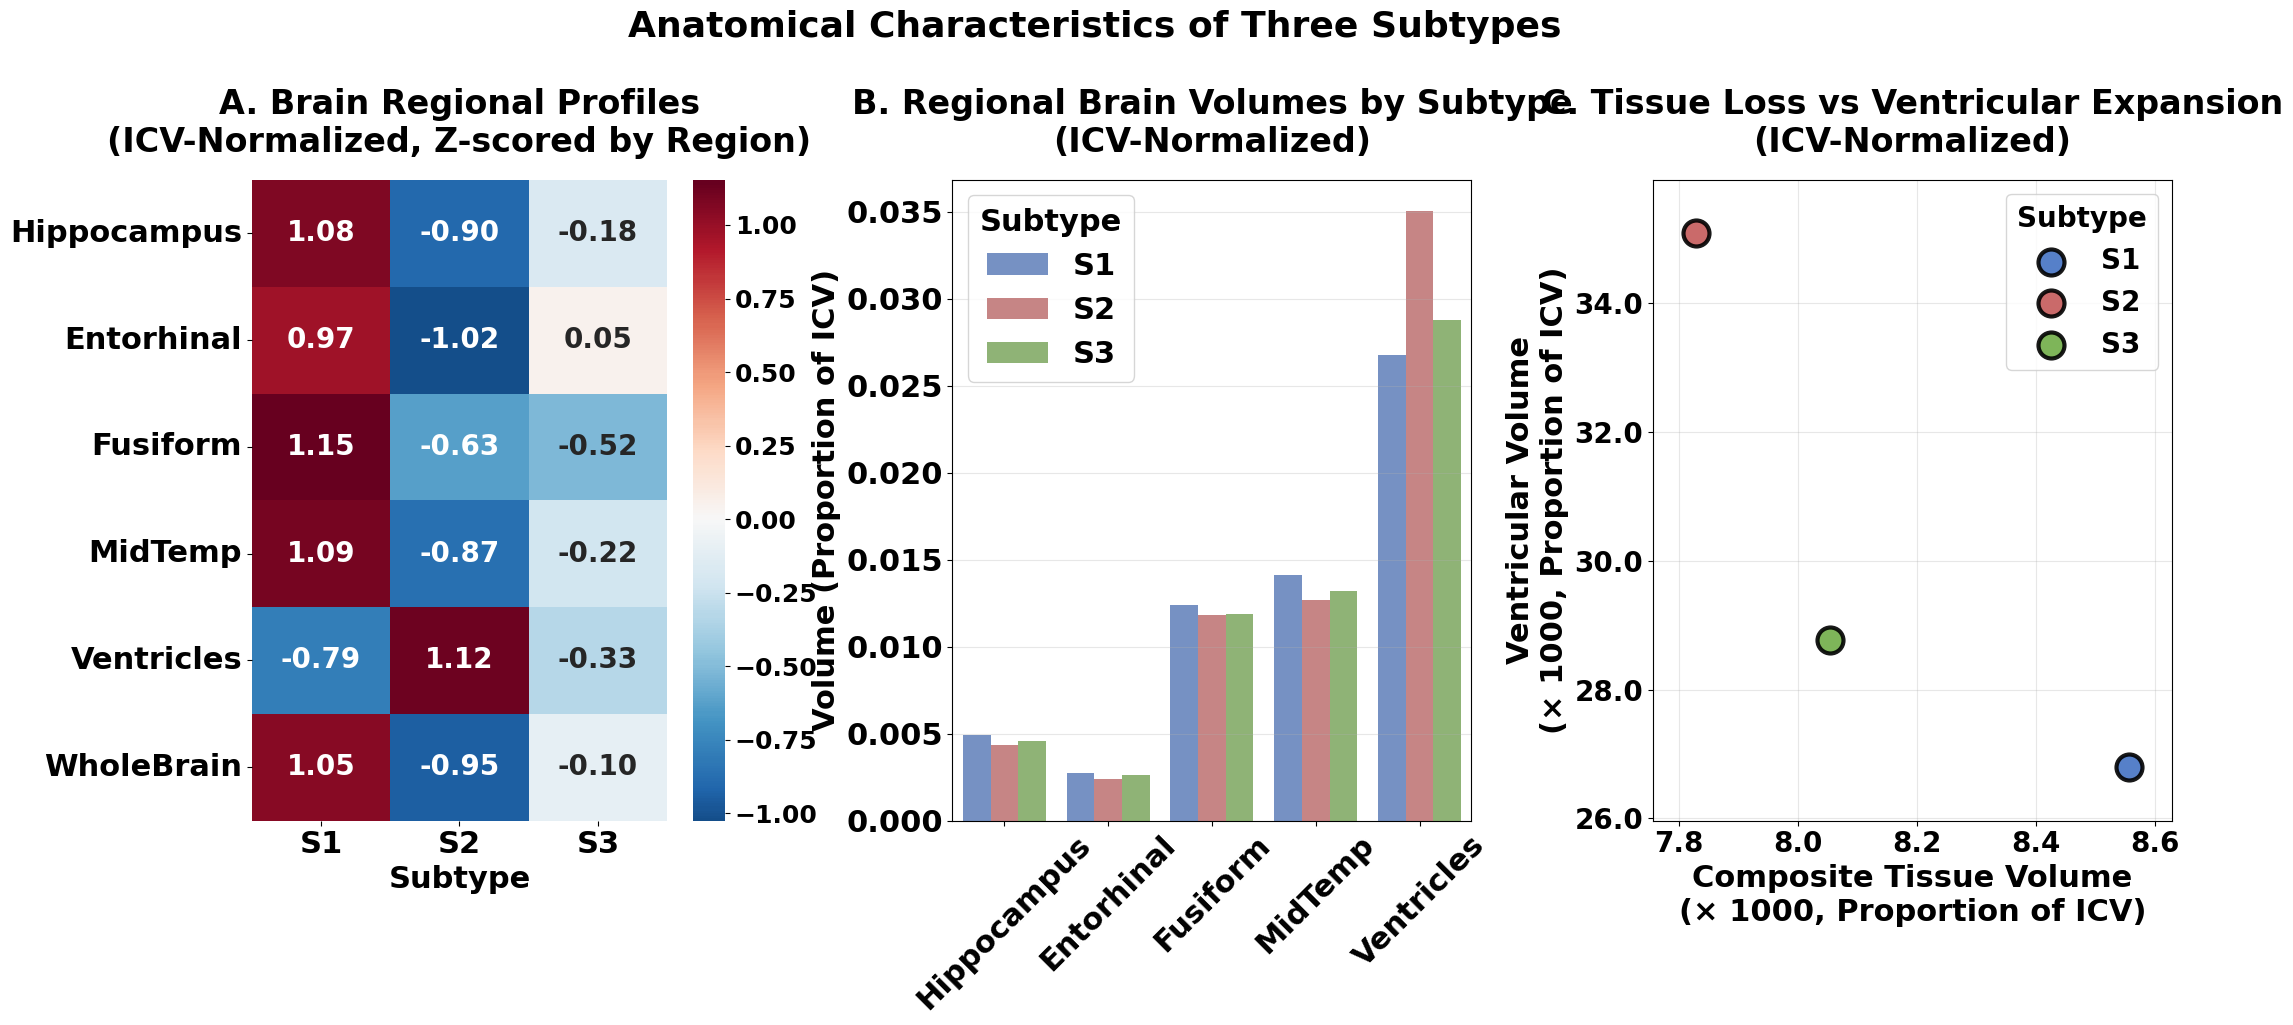

In [8]:
def create_three_anatomical_plots_fixed():
    plt.style.use('default')
    fig, axes = plt.subplots(1, 3, figsize=(22, 10))
    fig.suptitle('Anatomical Characteristics of Three Subtypes',
                 fontsize=26, fontweight='bold', y=1.02)

    ax1, ax2, ax3 = axes[0], axes[1], axes[2]

    # STEP 1: CREATE ICV-NORMALIZED VARIABLES
    anatomical_vars = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'Ventricles', 'WholeBrain']
    region_labels = ['Hippocampus', 'Entorhinal', 'Fusiform', 'MidTemp', 'Ventricles', 'WholeBrain']
    
    # Create ICV-normalized versions
    for var in anatomical_vars:
        if var in df_anatomical.columns and 'ICV' in df_anatomical.columns:
            df_anatomical[f'{var}_icv_norm'] = df_anatomical[var] / df_anatomical['ICV']
    
    # Use ICV-normalized variables for analysis
    icv_norm_vars = [f'{var}_icv_norm' for var in anatomical_vars]
    
    colors = ['#4472C4', '#C55A5A', '#70AD47']
    subtypes = ['S1', 'S2', 'S3']

    # ------------------ PLOT 1: Heatmap ------------------
    heatmap_data = []
    for var, label in zip(icv_norm_vars, region_labels):
        if var in df_anatomical.columns:
            row = []
            for subtype in subtypes:
                mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
                row.append(mean_val)
            heatmap_data.append(row)

    if heatmap_data:
        heatmap_df = pd.DataFrame(heatmap_data, columns=subtypes, index=region_labels)
        
        # Z-score normalization (now justified!)
        heatmap_normalized = heatmap_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
        
        # Draw heatmap
        heatmap = sns.heatmap(
            heatmap_normalized,
            annot=True,
            cmap='RdBu_r',
            center=0,
            ax=ax1,
            fmt='.2f',
            annot_kws={'fontsize': 20}
        )

        # Bold annotation texts
        for text in ax1.texts:
            text.set_fontweight('bold')

        # Make the colorbar label bold
        colorbar = heatmap.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=18)
        for label in colorbar.ax.get_yticklabels():
            label.set_fontweight('bold')

        # FIXED TITLE - Clear and accurate
        ax1.set_title('A. Brain Regional Profiles\n(ICV-Normalized, Z-scored by Region)',
                      fontweight='bold', fontsize=24, pad=20)
        ax1.set_xlabel('Subtype', fontweight='bold', fontsize=22)
        ax1.tick_params(axis='x', labelsize=22)
        ax1.tick_params(axis='y', labelsize=22)
        for label in ax1.get_xticklabels() + ax1.get_yticklabels():
            label.set_fontweight('bold')
        ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

    # ------------------ PLOT 2: Bar Plot (Exclude WholeBrain) ------------------
    # Remove WholeBrain from bar plot to prevent scale domination
    bar_plot_vars = [var for var, label in zip(icv_norm_vars, region_labels) if label != 'WholeBrain']
    bar_plot_labels = [label for label in region_labels if label != 'WholeBrain']
    
    plot_data = []
    for var, label in zip(bar_plot_vars, bar_plot_labels):
        if var in df_anatomical.columns:
            for subtype in subtypes:
                mean_val = df_anatomical[df_anatomical['Subtype'] == subtype][var].mean()
                plot_data.append({'Region': label, 'Subtype': subtype, 'Volume': mean_val})
    
    plot_df = pd.DataFrame(plot_data)

    sns.barplot(data=plot_df, x='Region', y='Volume', hue='Subtype',
                palette=colors, ax=ax2, alpha=0.8)

    ax2.set_title('B. Regional Brain Volumes by Subtype\n(ICV-Normalized)',
                  fontweight='bold', fontsize=24, pad=20)
    ax2.set_ylabel('Volume (Proportion of ICV)', fontweight='bold', fontsize=22)
    ax2.tick_params(axis='x', rotation=45, labelsize=22)
    ax2.tick_params(axis='y', labelsize=22)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    legend2 = ax2.legend(title='Subtype', fontsize=22, title_fontsize=22, loc='upper left')
    legend2.get_title().set_fontweight('bold')
    for text in legend2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xlabel('', fontsize=0)

    # ------------------ PLOT 3: Scatter ------------------
    tissue_vars = icv_norm_vars[:4]  # First 4 tissue regions
    tissue_means, vent_means = [], []

    for subtype in subtypes:
        subtype_data = df_anatomical[df_anatomical['Subtype'] == subtype]
        tissue_vals = [subtype_data[var].mean() for var in tissue_vars if var in df_anatomical.columns]
        tissue_means.append(np.mean(tissue_vals))
        
        # Ventricles as proportion of ICV
        vent_var = 'Ventricles_icv_norm'
        if vent_var in df_anatomical.columns:
            vent_means.append(subtype_data[vent_var].mean())
        else:
            vent_means.append(0)

    for i, subtype in enumerate(subtypes):
        ax3.scatter(tissue_means[i], vent_means[i],
                    s=350, c=colors[i], alpha=0.9,
                    edgecolors='black', linewidth=3, label=subtype)

    # Format axes with better scaling and readable labels
    ax3.set_xlabel('Composite Tissue Volume\n(× 1000, Proportion of ICV)',
                   fontweight='bold', fontsize=22)
    ax3.set_ylabel('Ventricular Volume\n(× 1000, Proportion of ICV)', fontweight='bold', fontsize=22)
    ax3.set_title('C. Tissue Loss vs Ventricular Expansion\n(ICV-Normalized)',
                  fontweight='bold', fontsize=24, pad=20)
    
    # Scale the axes to show values × 1000 for better readability
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*1000:.1f}'))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y*1000:.1f}'))
    
    # Set better axis limits with some padding
    x_vals = [tissue_means[i] for i in range(len(subtypes))]
    y_vals = [vent_means[i] for i in range(len(subtypes))]
    
    x_range = max(x_vals) - min(x_vals)
    y_range = max(y_vals) - min(y_vals)
    
    ax3.set_xlim(min(x_vals) - 0.1*x_range, max(x_vals) + 0.1*x_range)
    ax3.set_ylim(min(y_vals) - 0.1*y_range, max(y_vals) + 0.1*y_range)
    
    ax3.tick_params(axis='x', labelsize=20)
    ax3.tick_params(axis='y', labelsize=20)
    for label in ax3.get_xticklabels() + ax3.get_yticklabels():
        label.set_fontweight('bold')
    ax3.grid(True, alpha=0.3)
    
    legend3 = ax3.legend(title='Subtype', fontsize=20, title_fontsize=20, loc='upper right')
    legend3.get_title().set_fontweight('bold')
    for text in legend3.get_texts():
        text.set_fontweight('bold')

    # Final layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.35)

    # Save to PDF
    fig.savefig("anatomical_subtypes_plot_fixed.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    return fig

# SUMMARY OF CHANGES MADE:
print("="*60)
print("FIXES APPLIED:")
print("="*60)
print("1. ✅ ICV NORMALIZATION: Created volume/ICV ratios")
print("2. ✅ Z-SCORE JUSTIFIED: 261x mean difference requires normalization")
print("3. ✅ CLEAR TITLES: Removed confusing 'Standardized by Row'")
print("4. ✅ PROPER LABELS: 'Proportion of ICV' instead of generic 'Volume'")
print("5. ✅ WHOLBRAIN REMOVED: From bar plot to prevent scale domination")
print("6. ✅ SCATTER PLOT SCALING: Better axis formatting and readability")
print("="*60)

# Run the fixed function
fig = create_three_anatomical_plots_fixed()